Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
#from pandas.core.common import SettingWithCopyWarning
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 9 - Modeling Volatility with GARCH class models

6장에서 사용한 모델링 방법의 한계
- ARIMA 같은 모델링은 변동성이 일정하지 않은 경우를 모델링하지 못한다.
- 변동성의 변화를 Log 변환이나 Box-Cox 변환으로 처리할 수 있지만 한계가 있다.

이번 장에서 다룰 내용은 조건부 이분산성 (Conditional Heteroskedasticity)
- 변동성이 과거의 변동성과 상관이 있는 경우
- 예를 들어 다음과 같은 경우가 가능 하다
  - 어떤 회사의 주가가 속보에 의해서 급락
  - 해당 급락이 펀드들의 위험 관리 시스템에 포착됨
  - 펀드들이 주식을 매도함
  - 주가가 더 떨어짐
- 4장에서 언급했던 변동성이 뭉쳐 있는 현상도 관련이 있다.

변동성은 금융시장에서 중요한 개념
- 옵션 가격 결정에 사용됨
  - 옵션의 기반 자산의 변동성에 대한 Black-Scholes 모델을 사용
- 위험 관리에 중요한 요소임
  - 포트폴리오의 Value-at-Risk(VaR) 지표, Sharp ratio 등등에 사용됨
- 변동성 매매(Volatility trading)에 사용됨
  - 일반적으로 트레이더는 상승/하락을 예측하여 매매하지만, 변동성을 기반으로 매매하는 것도 가능하다.
  - 판데믹같은 변동성이 극대화될 때 매우 효과적이다.
  - 예를 들어 변동성 지수(VIX)는 S&P 500 지수의 변화를 기반으로 한다.

이번 장에서는 여러 종류의 GARCH(Generalized Autoregressive Conditional Heteroskedasticity) 모델을 다룬다.
- ARCH를 이용한 모델링 
- GARCH를 이용한 모델링
- GARCH 모델을 이용해서 예측
- CCC-GARCH 모델을 이용해서 여러 개의 변동성을 같이 예측
- DCC-GARCH 모델을 이용해서 조건부 공분산 행열 (conditional covariance matrix)을 예측

## 9.1 Modeling stock returns' volatility with ARCH models


Autoregressive Conditional Heteroskedasticity (ARCH) 모델
- 이전 에러의 함수로 에러의 분산을 표현한다.
- 에러의 분산이 자동 회귀 모델이라고 가정

세부 내용을 설명하면 다음과 같다.
- ARCH 모델을 표현하는 공식
  - <img src="image/fig_09_01.png" width="300"/>
- ε는 시계를 분석할 때 residual에 해당하는 부분.
  - mean-corrected return, error term, innovations
- μ는 시계열 분석에서 설명되는 부분
  - 앞에서 나온 trend + seasonal
  - 예
    - zero-mean process
    - constant mean process
    - linear models 로 추정되는 경우 (AR, ARMA, ARIMA, HAR)
- 두번째 공식은 에러는 N(0,1)를 따르는 z<sub>t</sub>와 분산으로 표현된다는 뜻
- 세번째 공식이 ARCH formula (ω > 0, α<sub>i</sub> >= 0)
  - unconditional 분산과 conditional 분산으로 구성
  - conditional 분산은 과거의 에러의 함수
  - unconditional 분산은 상수
  - 몇 번의 과거 에러까지 사용하는지 여부 (q)
  - 에러는 zero-mean에 stationary 해야 한다.

ARCH 모델의 장단점
- 장점은
  - 주식의 수익율과 비슷하게 Excess kurtosis 형태가 된다 (fat tail)
- 단점은
  - positive, negative 양쪽이 동일하다.
  - 크고 고립된 충격에 반응하는 데 느리다.

### How to do it...

1. Import the libraries:

In [7]:
import pandas as pd
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [8]:
RISKY_ASSET = "GOOG"
START_DATE = "2015-01-01"
END_DATE = "2021-12-31"

3. Download data from Yahoo Finance:

In [9]:
df = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE)
#                 end=END_DATE,
#                 adjusted=True)

print(f"Downloaded {df.shape[0]} rows of data.")

[*********************100%***********************]  1 of 1 completed

Downloaded 1762 rows of data.


* <span style="color:red">yfinance.download 함수에 adjusted 인자가 없음</span>

4. Calculate daily returns:

- return의 숫자가 작을 경우 scipy 최적화 알고리즘에 불안정성 문제가 있어서 return값에 100을 곱해서 %로 변경.

Average return: 0.11%


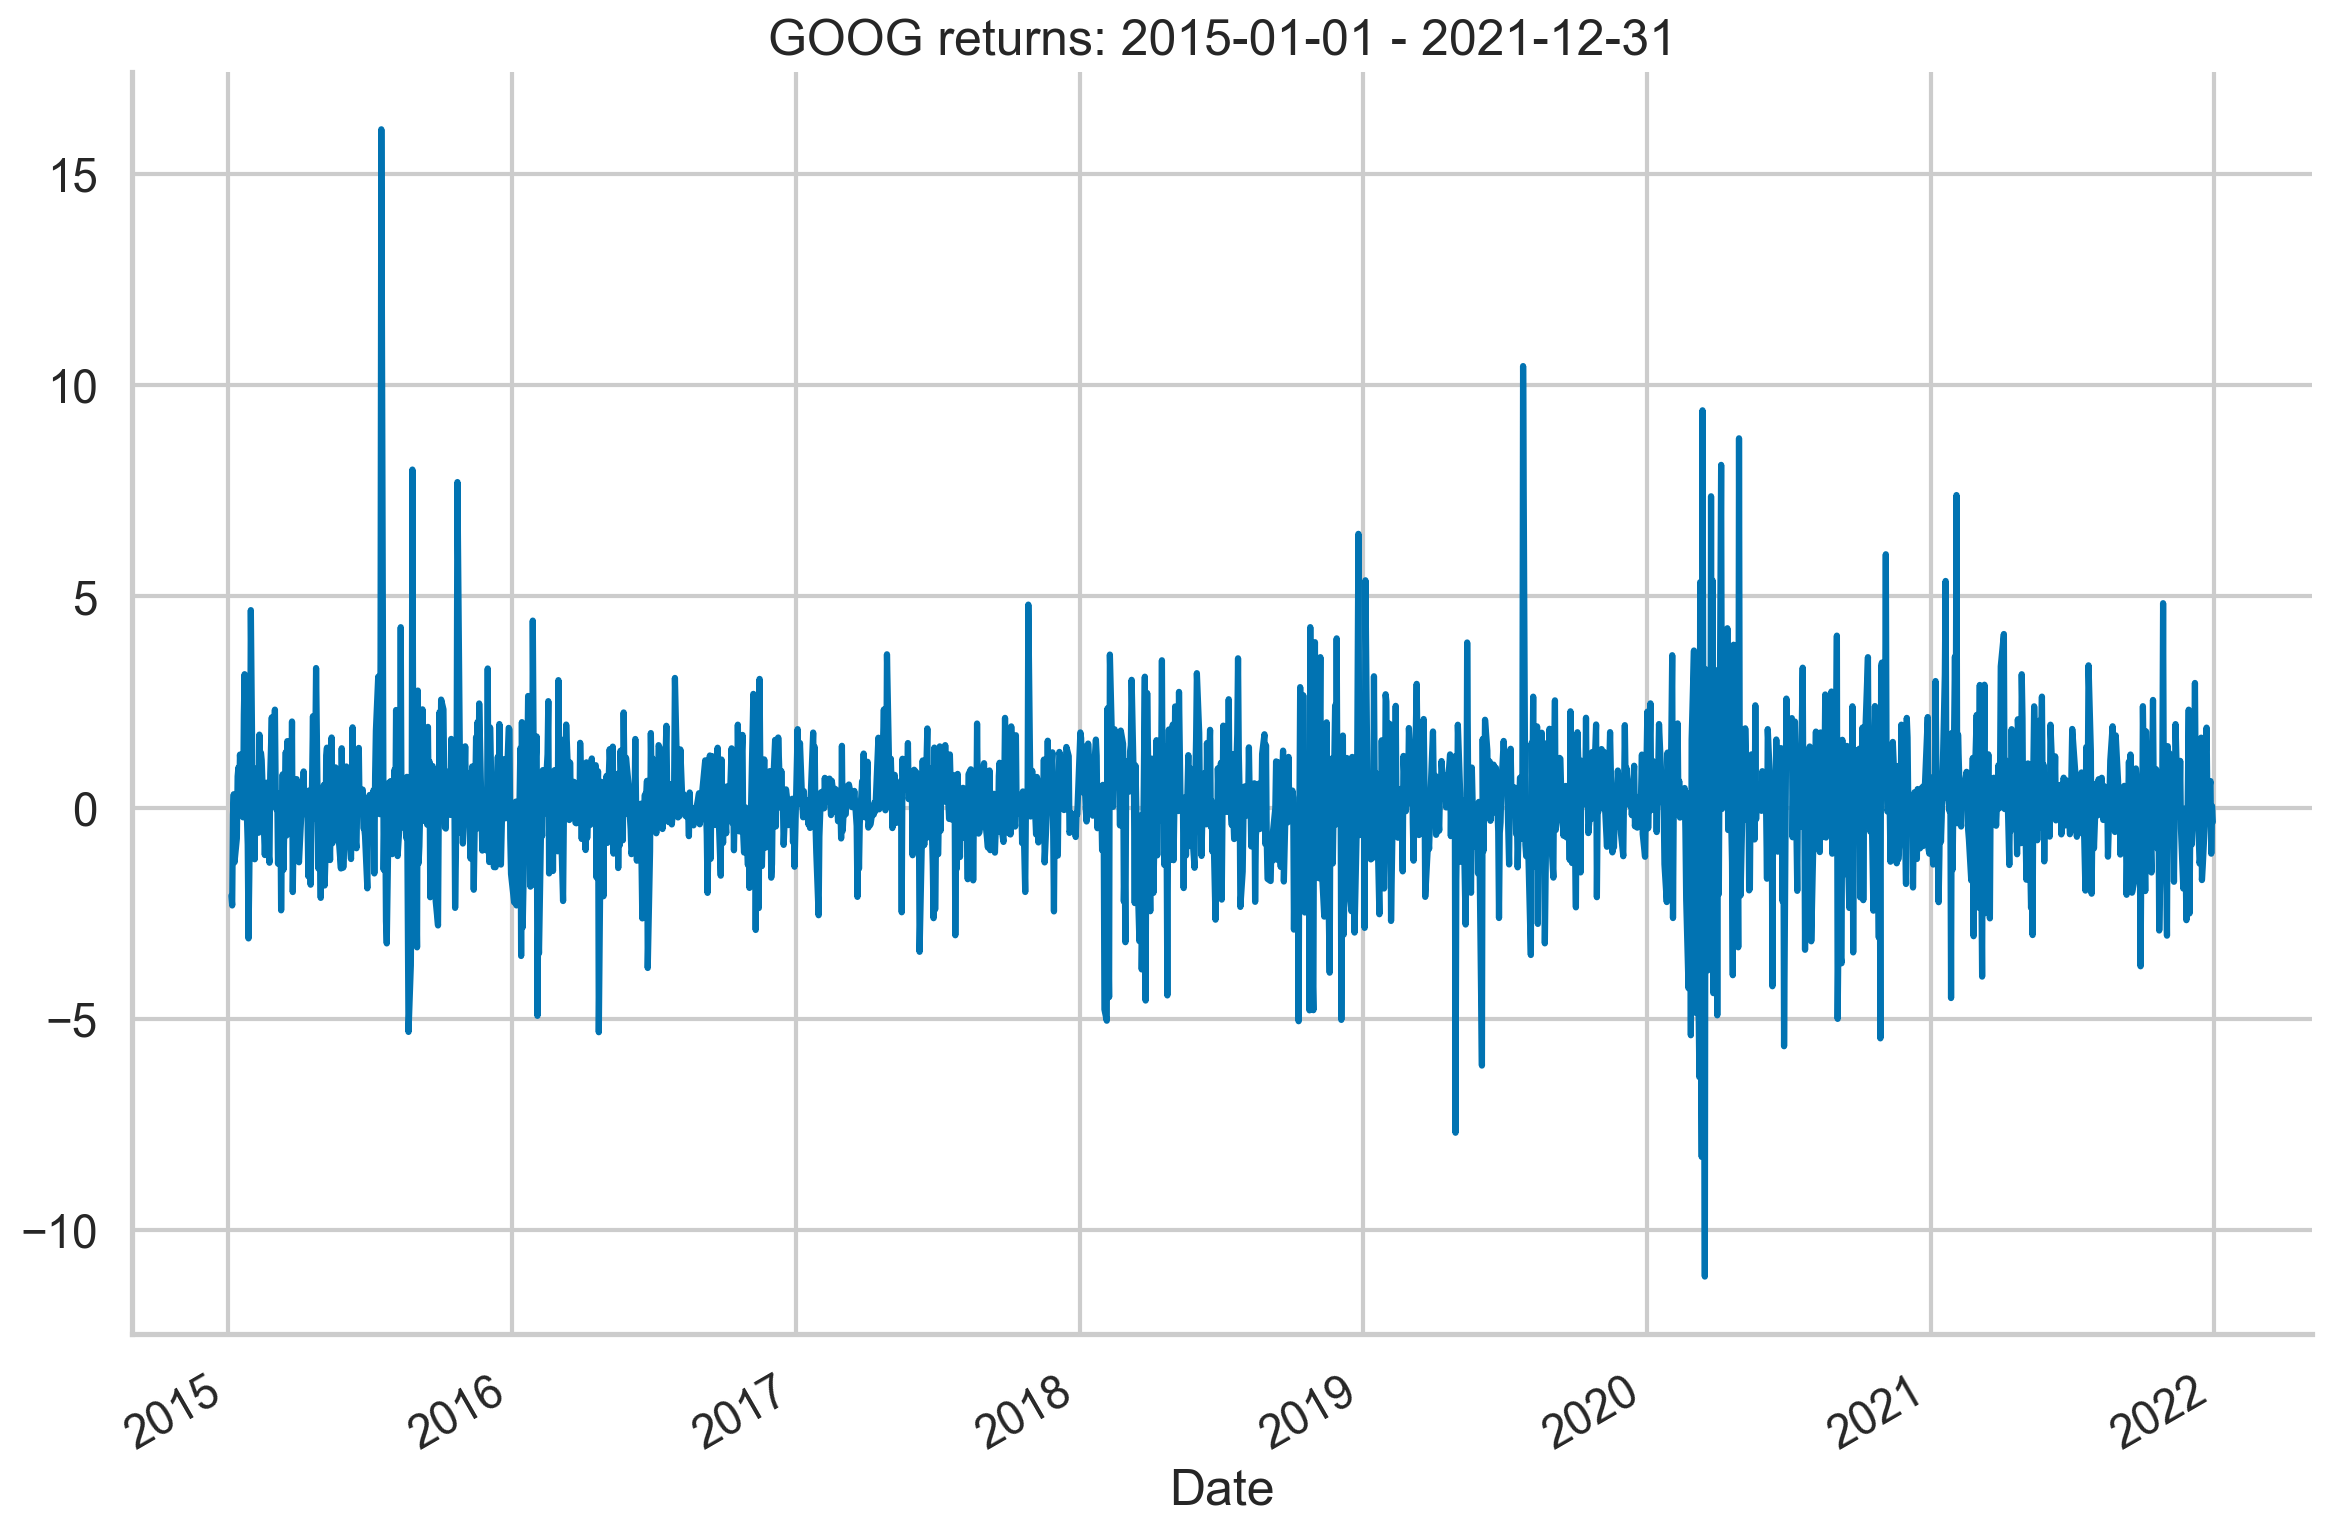

In [11]:
returns = 100 * df["Adj Close"].pct_change().dropna()
returns.name = "asset_returns"
print(f"Average return: {round(returns.mean(), 2)}%")
returns.plot(title=f"{RISKY_ASSET} returns: {START_DATE} - {END_DATE}");

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("images/figure_9_1", dpi=200)

5. Specify the ARCH model:

- ARCH(1) 모델을 사용 (q=1)
- zero-mean을 사용

In [12]:
model = arch_model(returns, mean="Zero", vol="ARCH", p=1, q=0)

6. Estimate the model and print the summary:

- scikit-learn과는 다르게 모델을 만들 때 데이터를 넘긴다.

In [13]:
fitted_model = model.fit(disp="off")
print(fitted_model.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3301.32
Distribution:                  Normal   AIC:                           6606.64
Method:            Maximum Likelihood   BIC:                           6617.59
                                        No. Observations:                 1761
Date:                   토, 10 12 2024   Df Residuals:                     1761
Time:                        02:17:02   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.8608      0.166     11.207  3.787e-29 [  1.535,  2.18

7. Plot the residuals and the conditional volatility:

- residual은 volatility로 나누어서 표준화 한다.
- volatility는 연율화 한다.

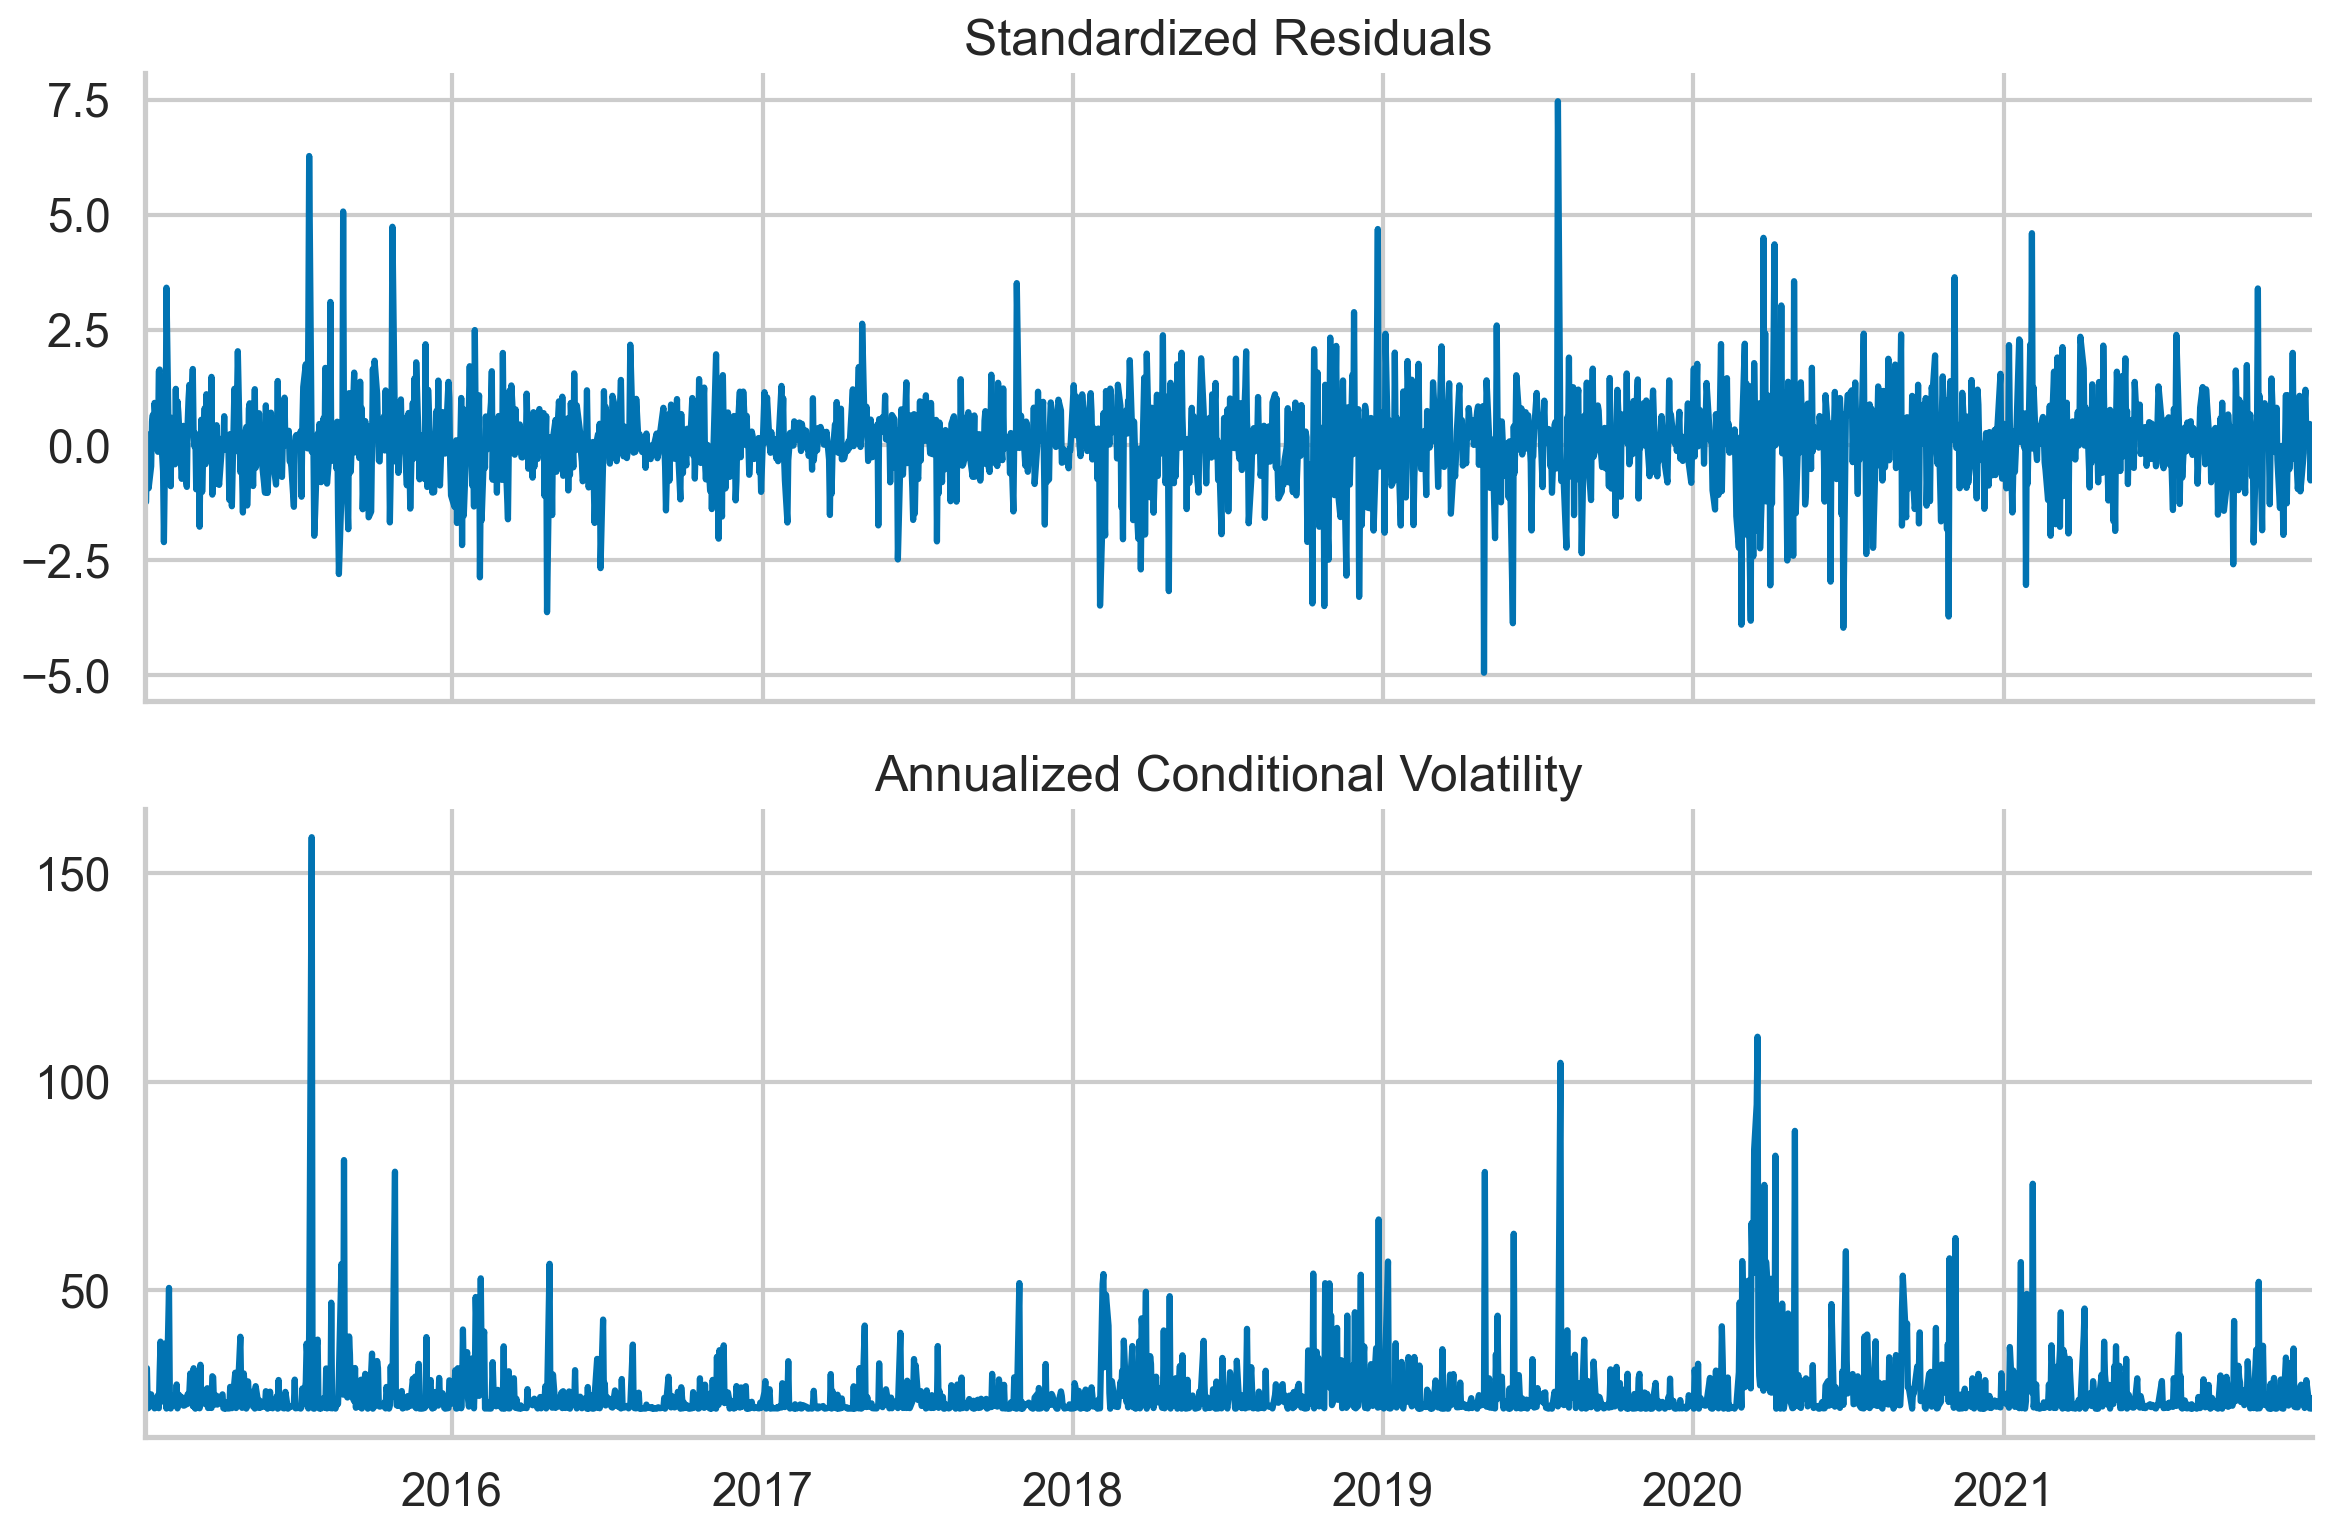

In [14]:
fitted_model.plot(annualize="D")

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("images/figure_9_2", dpi=200)

In the cell below we confirm that the standardized residuals are simply residuals divided by the conditional volatility.

In [15]:
diagnostics_dict = {
    "resids": fitted_model.resid,
    "conditional_volatility": fitted_model.conditional_volatility,
    "std_resid": fitted_model.std_resid,
    "std_resid_manual": fitted_model.resid / fitted_model.conditional_volatility,
}

df_diagnostics = pd.DataFrame(data = diagnostics_dict)
df_diagnostics

resids  conditional_volatility  std_resid  std_resid_manual
Date                                                                     
2015-01-05 -2.084566                1.661243  -1.254823         -1.254823
2015-01-06 -2.317708                1.874597  -1.236376         -1.236376
2015-01-07 -0.171316                1.976011  -0.086698         -0.086698
2015-01-08  0.315297                1.368190   0.230449          0.230449
2015-01-09 -1.295054                1.377897  -0.939877         -0.939877
...              ...                     ...        ...               ...
2021-12-23  0.131677                1.795159   0.073351          0.073351
2021-12-27  0.626259                1.366519   0.458288          0.458288
2021-12-28 -1.091412                1.417745  -0.769823         -0.769823
2021-12-29  0.038583                1.521182   0.025364          0.025364
2021-12-30 -0.342657                1.364310  -0.251158         -0.251158

[1761 rows x 4 columns]

### There's more

ARCH(1) 모델로 계산된 residual을 LM 테스트(Lagrange Multiplier test)로 평가해 본다.
- 처음 두 개의 숫자는 LM test statistic과 p-value 이다.
- 등분산적(homoskedastic)이라고 할 수 없으므로 ARCH 요소를 모두 추출해 내지 못했다.

In [16]:
from statsmodels.stats.diagnostic import het_arch
het_arch(fitted_model.resid)

(np.float64(98.03923018996215),
 np.float64(1.34422002168017e-16),
 10.320163892948203,
 4.3555067403667486e-17)

## 9.2 Modeling stock returns' volatility with GARCH models

Generalized Autoregressive Conditional Heteroskedasticity (GARCH) 모델
- ARCH 모델에 더해서 이동 평균 요소를 추가 (ARMA 모델의 개념을 적용)

세부 내용을 설명하면 다음과 같다.
- ARCH 모델을 표현하는 공식
  - <img src="image/fig_09_02.png" width="300"/>
- 세번째 공식의 추가부분 (ω > 0, α<sub>i</sub> >= 0, β<sub>i</sub> >= 0)
  - p: 분산은 과거 몇 번까지 참조하는지
  - q: 에러는 과거 몇 번까지 참조하는지
  - α<sub>i</sub> + β<sub>i</sub> < 1 조건을 만족하지 않으면 모델이 불안정해진다.
  - GARCH(0,q) = ARCH(q)
- 시계열의 평균을 추정할 때 사용하는 residual 제곱을 사용하면 p, q를 추정할 수 있다.
  - ACF/PACF를 참조한다.

GARCH 모델의 장단점
- ARCH 모델의 장단점과 비슷하지만,
  - 충격을 좀 더 잘 반영할 수 있다.


### How to do it...

1. Specify the GARCH model:

In [18]:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

2. Estimate the model and print the summary:

In [19]:
fitted_model = model.fit(disp="off")
print(fitted_model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3245.30
Distribution:                  Normal   AIC:                           6496.61
Method:            Maximum Likelihood   BIC:                           6513.03
                                        No. Observations:                 1761
Date:                   토, 10 12 2024   Df Residuals:                     1761
Time:                        02:17:03   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2878      0.187      1.540      0.123 [-7.83

3. Plot the residuals and the conditional volatility:

- ARCH일 때는 충격이 올 때 그때만 치솟고 바로 떨어지지만, GARCH는 치솟고 떨어지는데 더 시간이 걸린다.

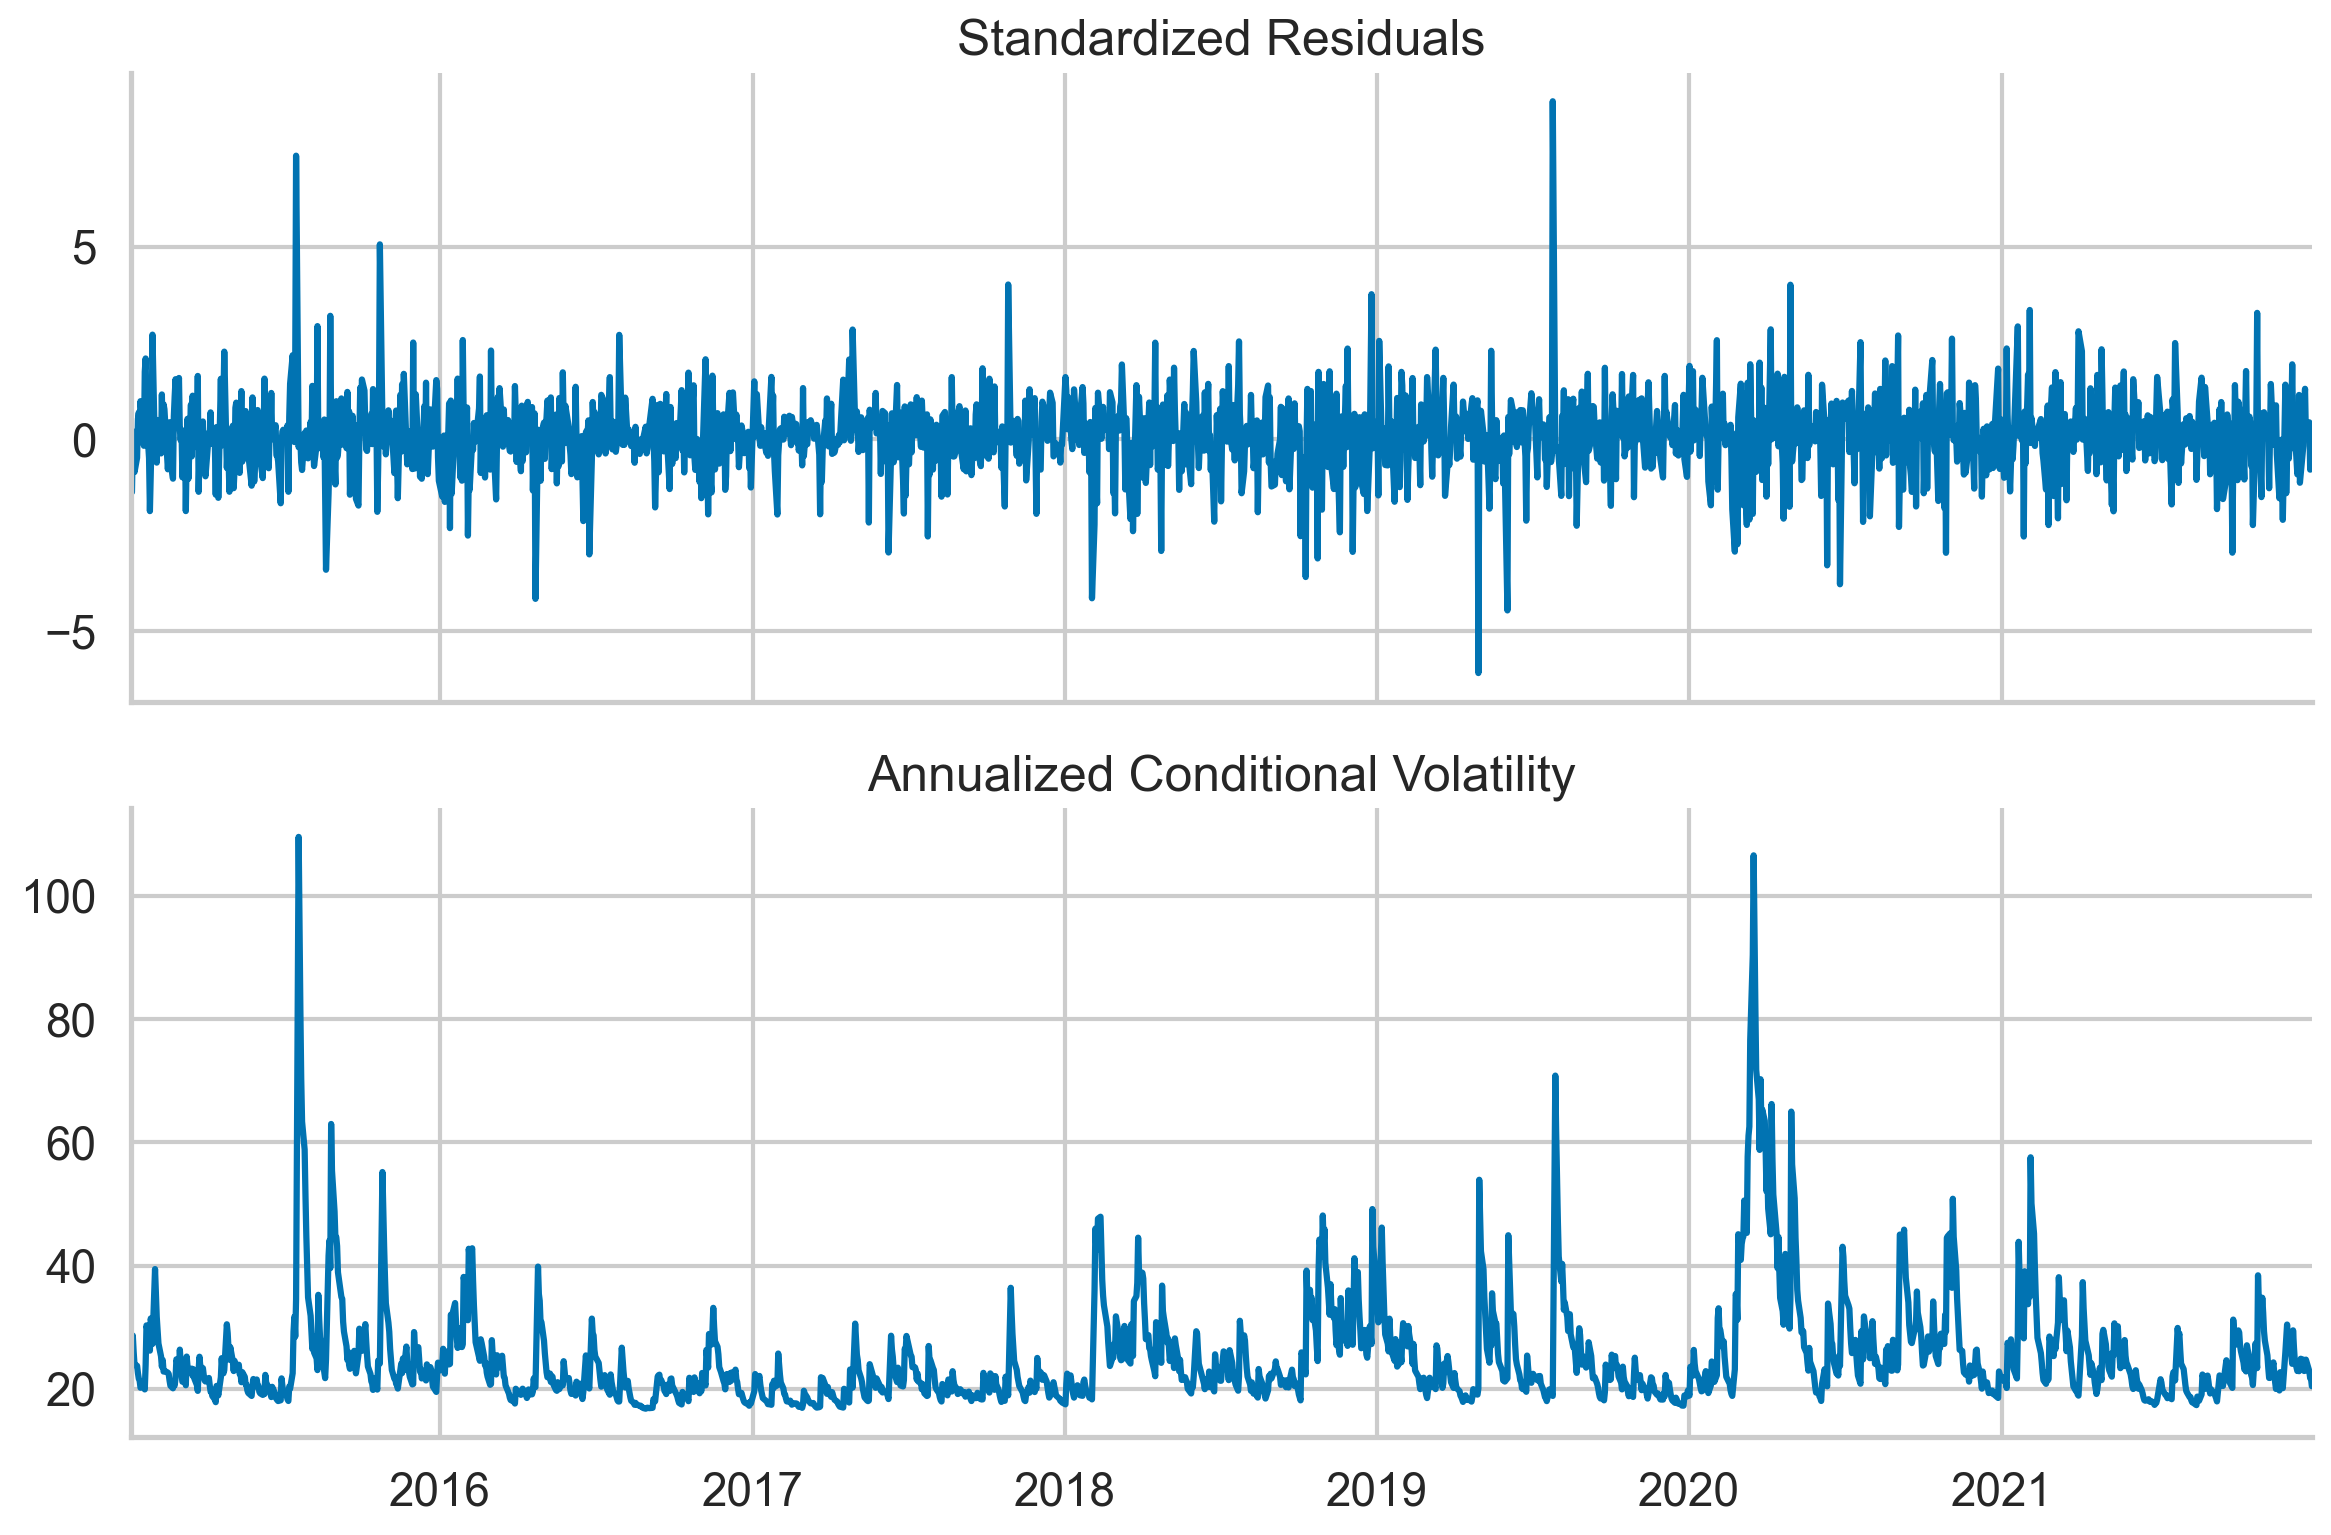

In [20]:
fitted_model.plot(annualize="D")

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("images/figure_9_3", dpi=200)

### There's more

기본 GARCH 모델의 확장들
- 평균 모델의 확장
  - zero-mean
  - constant mean
  - ARIMA 모델 (또는 확장)
  - 회귀 모델
  - 평균을 모델링할 때는 평균 모델과 변동성 모델을 순차적으로 최적화 하면 일관성이 없거나 비효율적일 수 있으므로 동시에 최적화 해야하는 것이 좋다.
- 변동성 모델의 확장
  - GJR-GARCH: return이 asymmetry한 것을 고려하는 확장
  - EGARCH: Exponential 확장
  - TGARCH: Threshold 확장
  - FIGARCH: non-stationary 확장
  - GARCH-MIDAS: short-term과 long-term을 구분하는 확장
  - CCC-/DCC-GARCH: 여러 변수를 같이 처리하는 확장
- 에러 분포의 확장
  - Student’s t-distribution
  - Skew-t distribution
  - Generalized Error Distribution
  - Skewed Generalized Error Distribution

## 9.3 Forecasting volatility using GARCH models

GARCH 모델을 이용해서 미래의 변동성을 예측해본다.

다음의 세가지 변동성 예측이 가능
- Analytical
  - 계산된 값을 이용해서 공식을 적용해서 미래의 값을 추정
  - E<sub>t</sub>[ε<sub>t+1</sub><sup>2</sup>] = σ<sub>t+1</sub><sup>2</sup> 을 사용한다.
  - 재귀적으로 적용해서 예측을 계속할 수 있다. 다만 3번째 공식이 선형이어야 한다.
- Simulation
  - 표준화된 ε<sub>t+1</sub> 값을 난수 발생기를 사용해서 생성해서 여러 시뮬레이션을 한 후 결과를 통합해서 추정값을 계산
- Bootstrap
  - 기존에 측정된 데이터와 계산된 파라메터들을 이용해서 표준화된 ε<sub>t+1</sub> 값을 계산.

### How to do it...

1. Import the libraries:

In [21]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from arch import arch_model

2. Download data from Yahoo Finance and calculate simple returns:

In [22]:
df = yf.download("MSFT",
                 start="2015-01-01",
                 end="2021-12-31")
#                 end="2021-12-31",
#                 adjusted=True)

returns = 100 * df["Adj Close"].pct_change().dropna()
returns.name = "asset_returns"

[*********************100%***********************]  1 of 1 completed


3. Specify the GARCH model:

- Student’s t 분포를 사용

In [23]:
model = arch_model(returns, mean="Zero", vol="GARCH", dist="t",
                   p=1, q=1)

4. Define the split date and fit the model:

In [24]:
SPLIT_DATE = datetime(2021, 1, 1)
fitted_model = model.fit(last_obs=SPLIT_DATE, disp="off")

5. Create and inspect the analytical forecasts:

forecast는 다음의 4가지 값을 제공
- mean
- variance
- residual_variance
- simulations (simulation과 bootstrap에서만 제공)

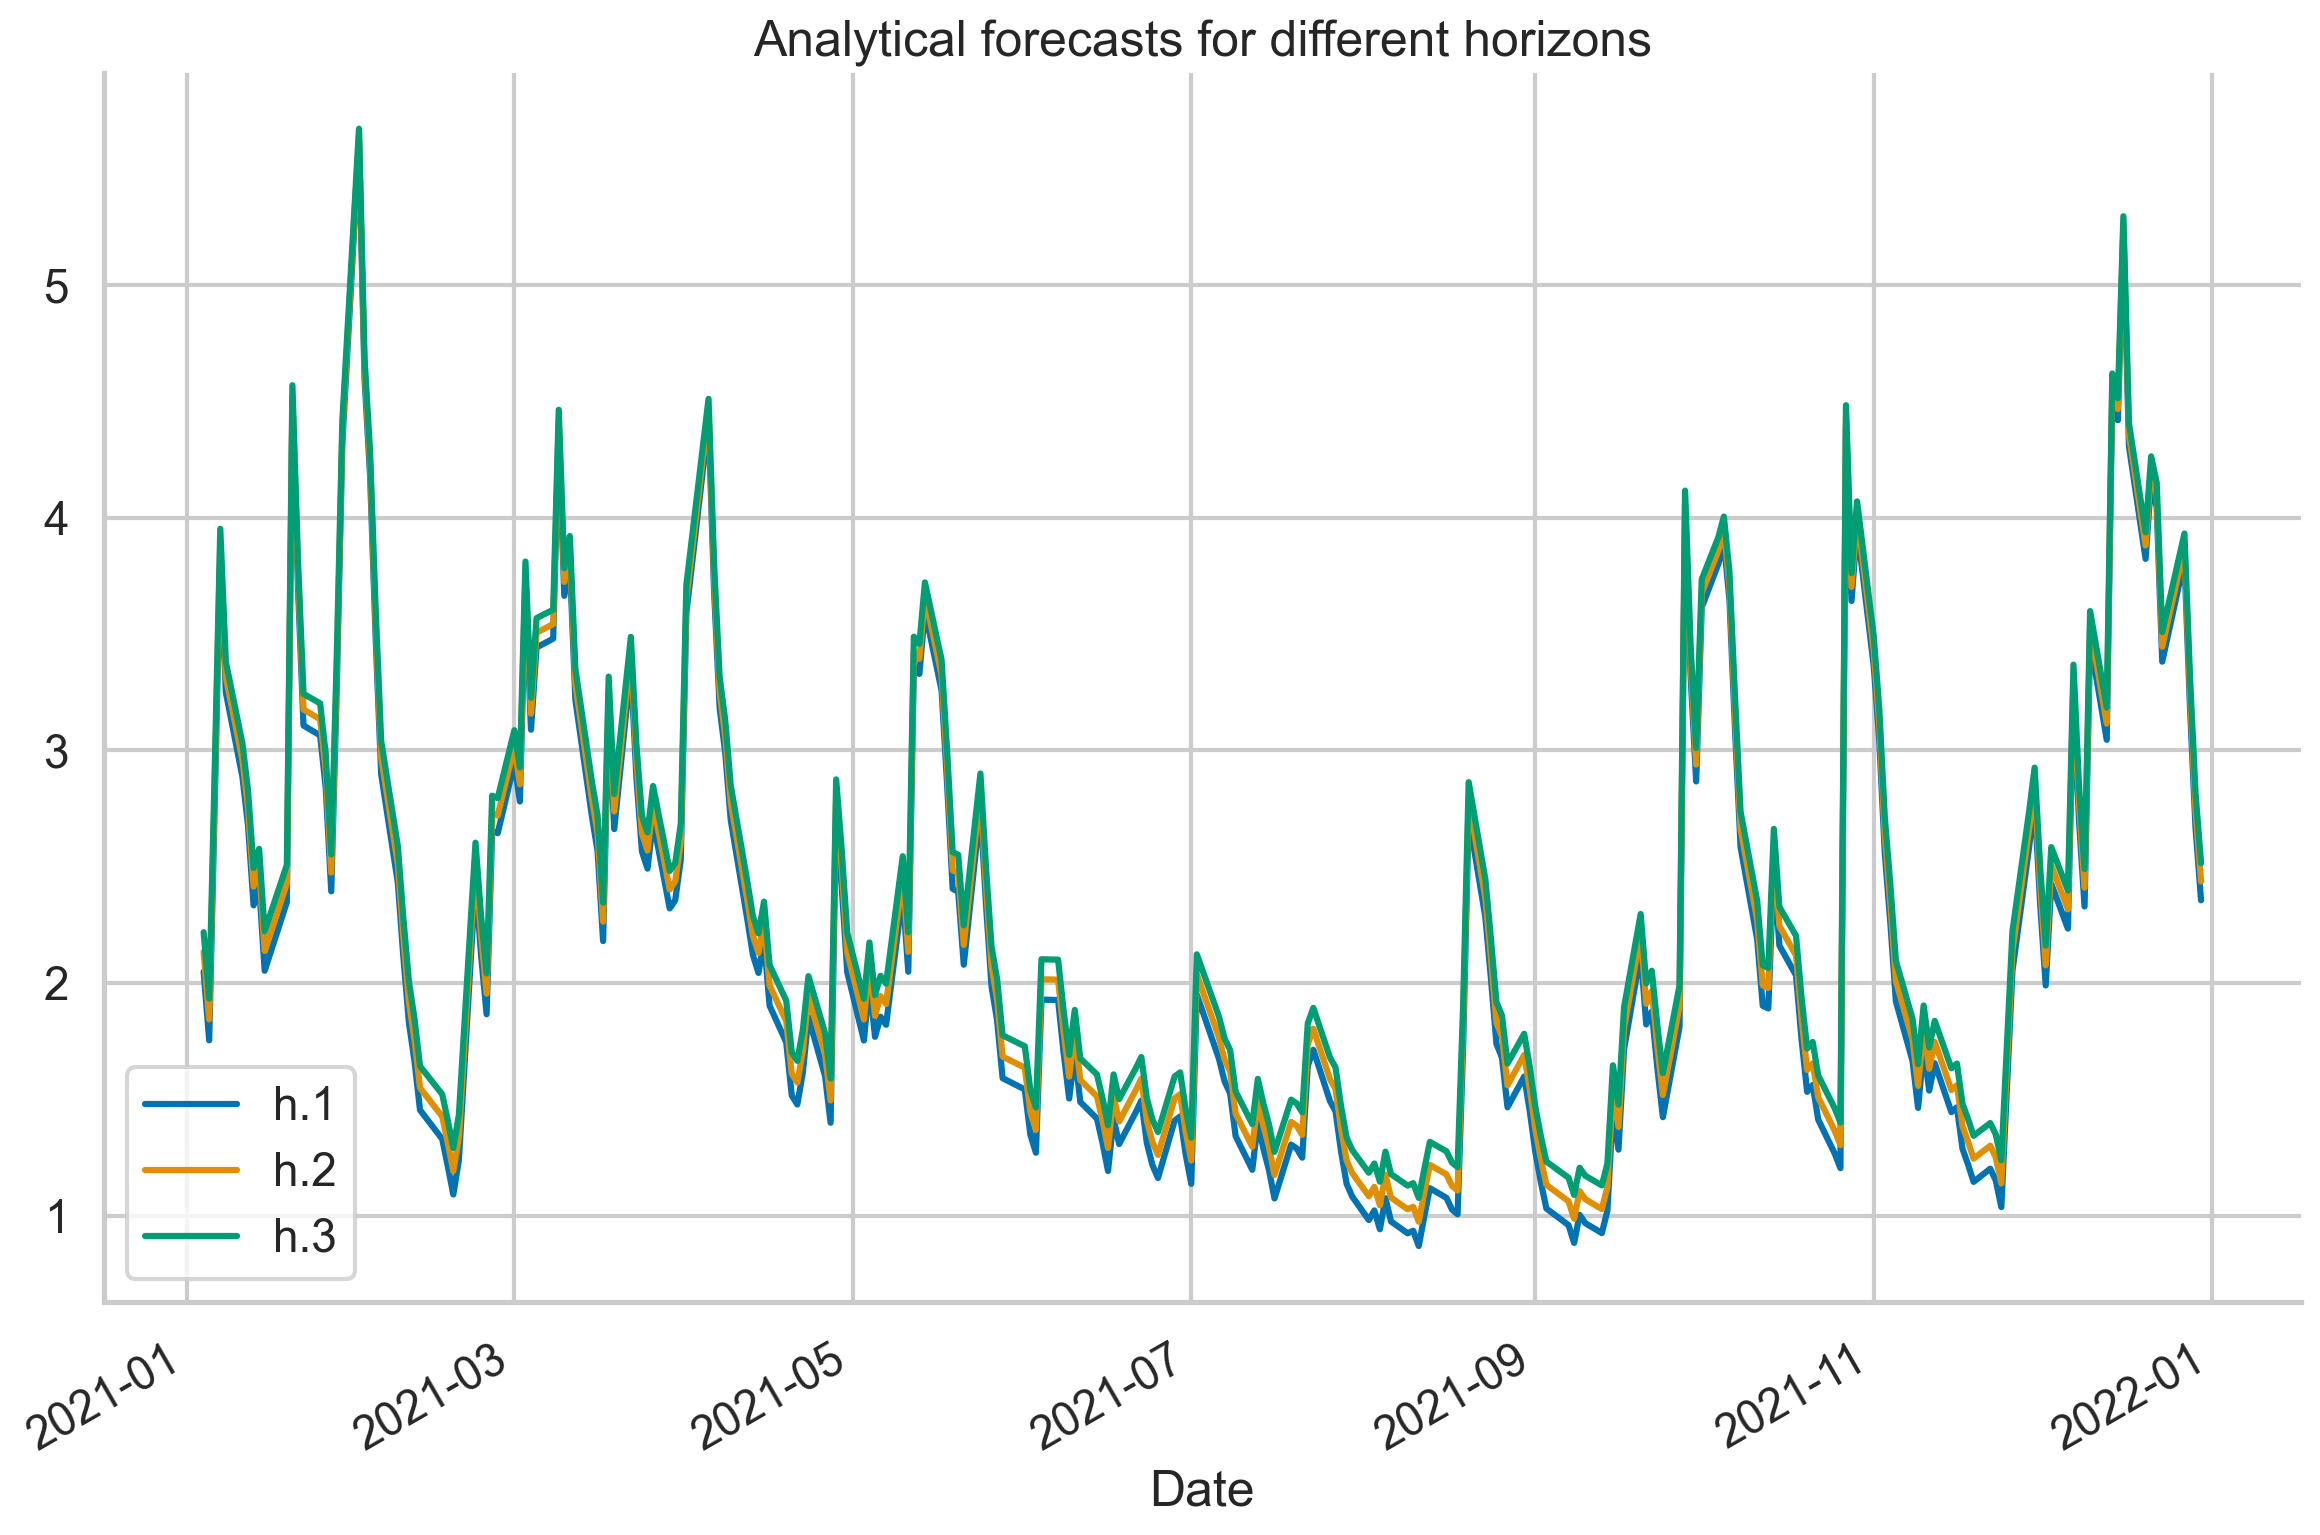

In [25]:
forecasts_analytical = fitted_model.forecast(horizon=3, 
                                             start=SPLIT_DATE,
                                             reindex=False)
forecasts_analytical.variance.plot(
    title="Analytical forecasts for different horizons"
)

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("images/figure_9_4", dpi=200)

In [26]:
forecasts_analytical.variance

h.1       h.2       h.3
Date                                    
2021-01-04  2.048968  2.134424  2.218525
2021-01-05  1.754037  1.844172  1.932876
2021-01-06  2.770921  2.844926  2.917758
2021-01-07  3.838424  3.895497  3.951665
2021-01-08  3.248879  3.315303  3.380674
...              ...       ...       ...
2021-12-23  3.380818  3.445149  3.508460
2021-12-27  3.817202  3.874612  3.931111
2021-12-28  3.185622  3.253050  3.319408
2021-12-29  2.666795  2.742452  2.816909
2021-12-30  2.355428  2.436024  2.515341

[251 rows x 3 columns]

6. Create and inspect the simulation forecasts:

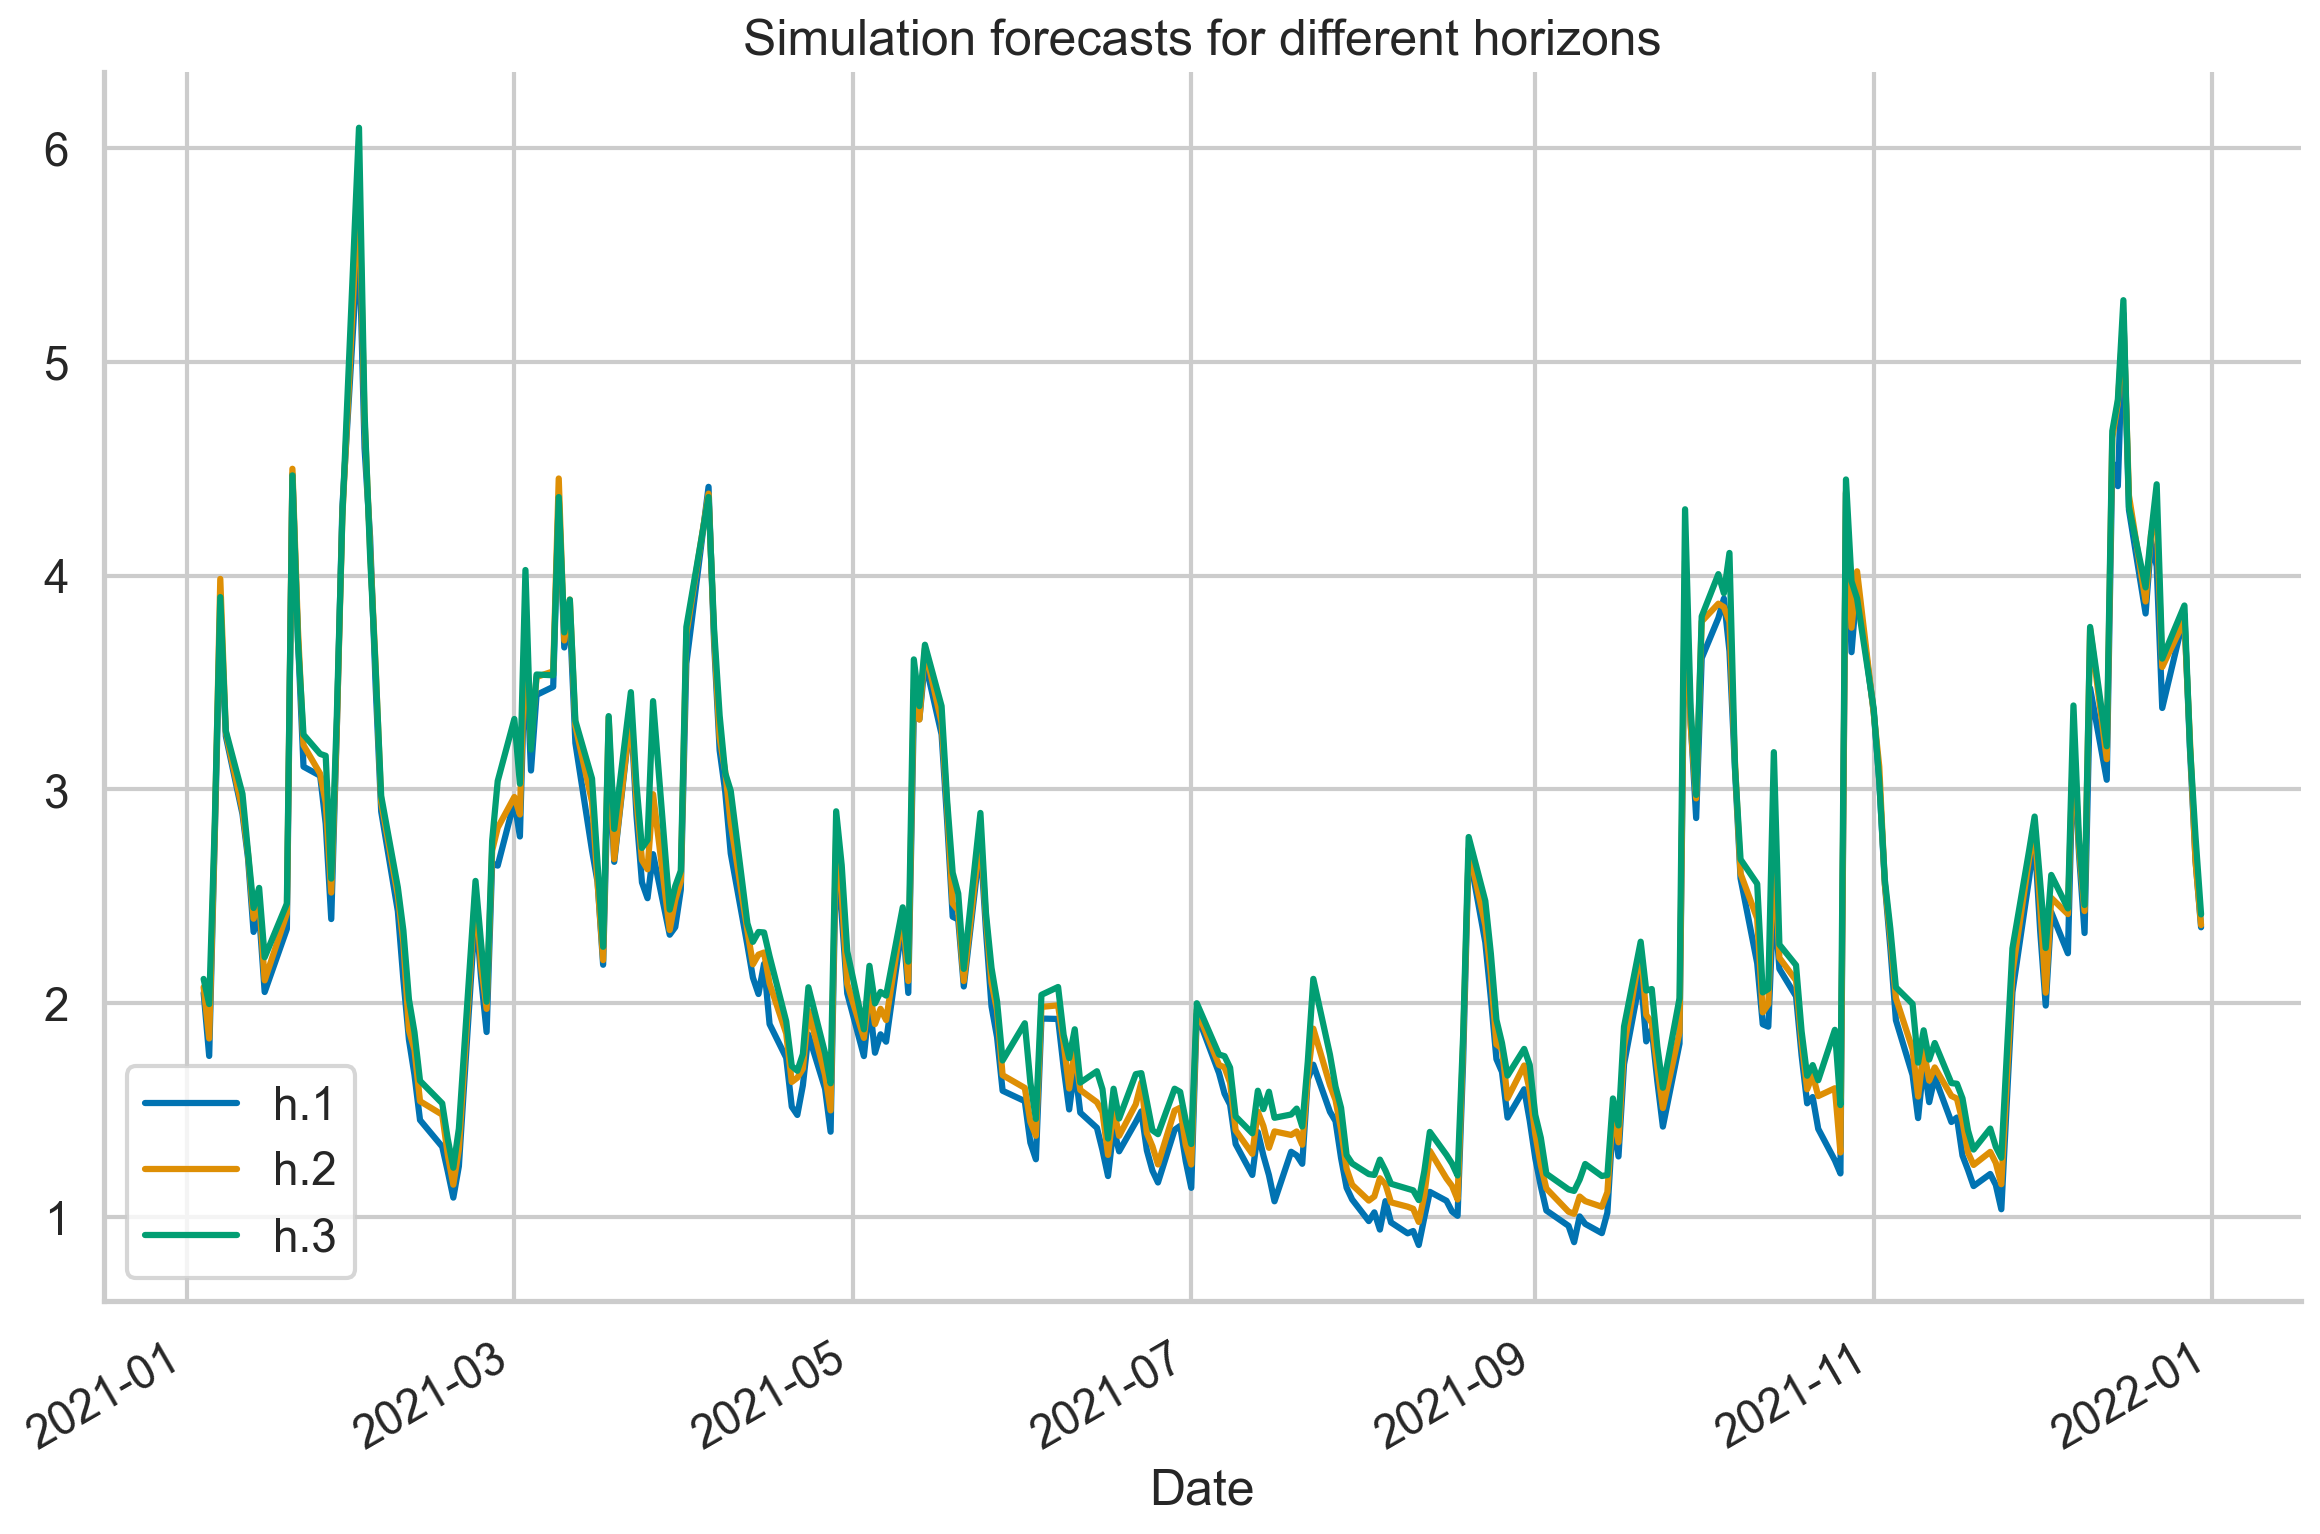

In [27]:
forecasts_simulation = fitted_model.forecast(horizon=3, 
                                             start=SPLIT_DATE,
                                             method="simulation",
                                             reindex=False)
forecasts_simulation.variance.plot(
    title="Simulation forecasts for different horizons"
)

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("images/figure_9_6", dpi=200)

In [28]:
forecasts_simulation.variance

h.1       h.2       h.3
Date                                    
2021-01-04  2.048968  2.075870  2.114074
2021-01-05  1.754037  1.835720  1.996708
2021-01-06  2.770921  2.790773  2.838772
2021-01-07  3.838424  3.984314  3.899245
2021-01-08  3.248879  3.267717  3.273468
...              ...       ...       ...
2021-12-23  3.380818  3.572397  3.611539
2021-12-27  3.817202  3.790288  3.860019
2021-12-28  3.185622  3.224409  3.201469
2021-12-29  2.666795  2.665530  2.779141
2021-12-30  2.355428  2.365661  2.415725

[251 rows x 3 columns]

7. Create and inspect the bootstrap forecasts:

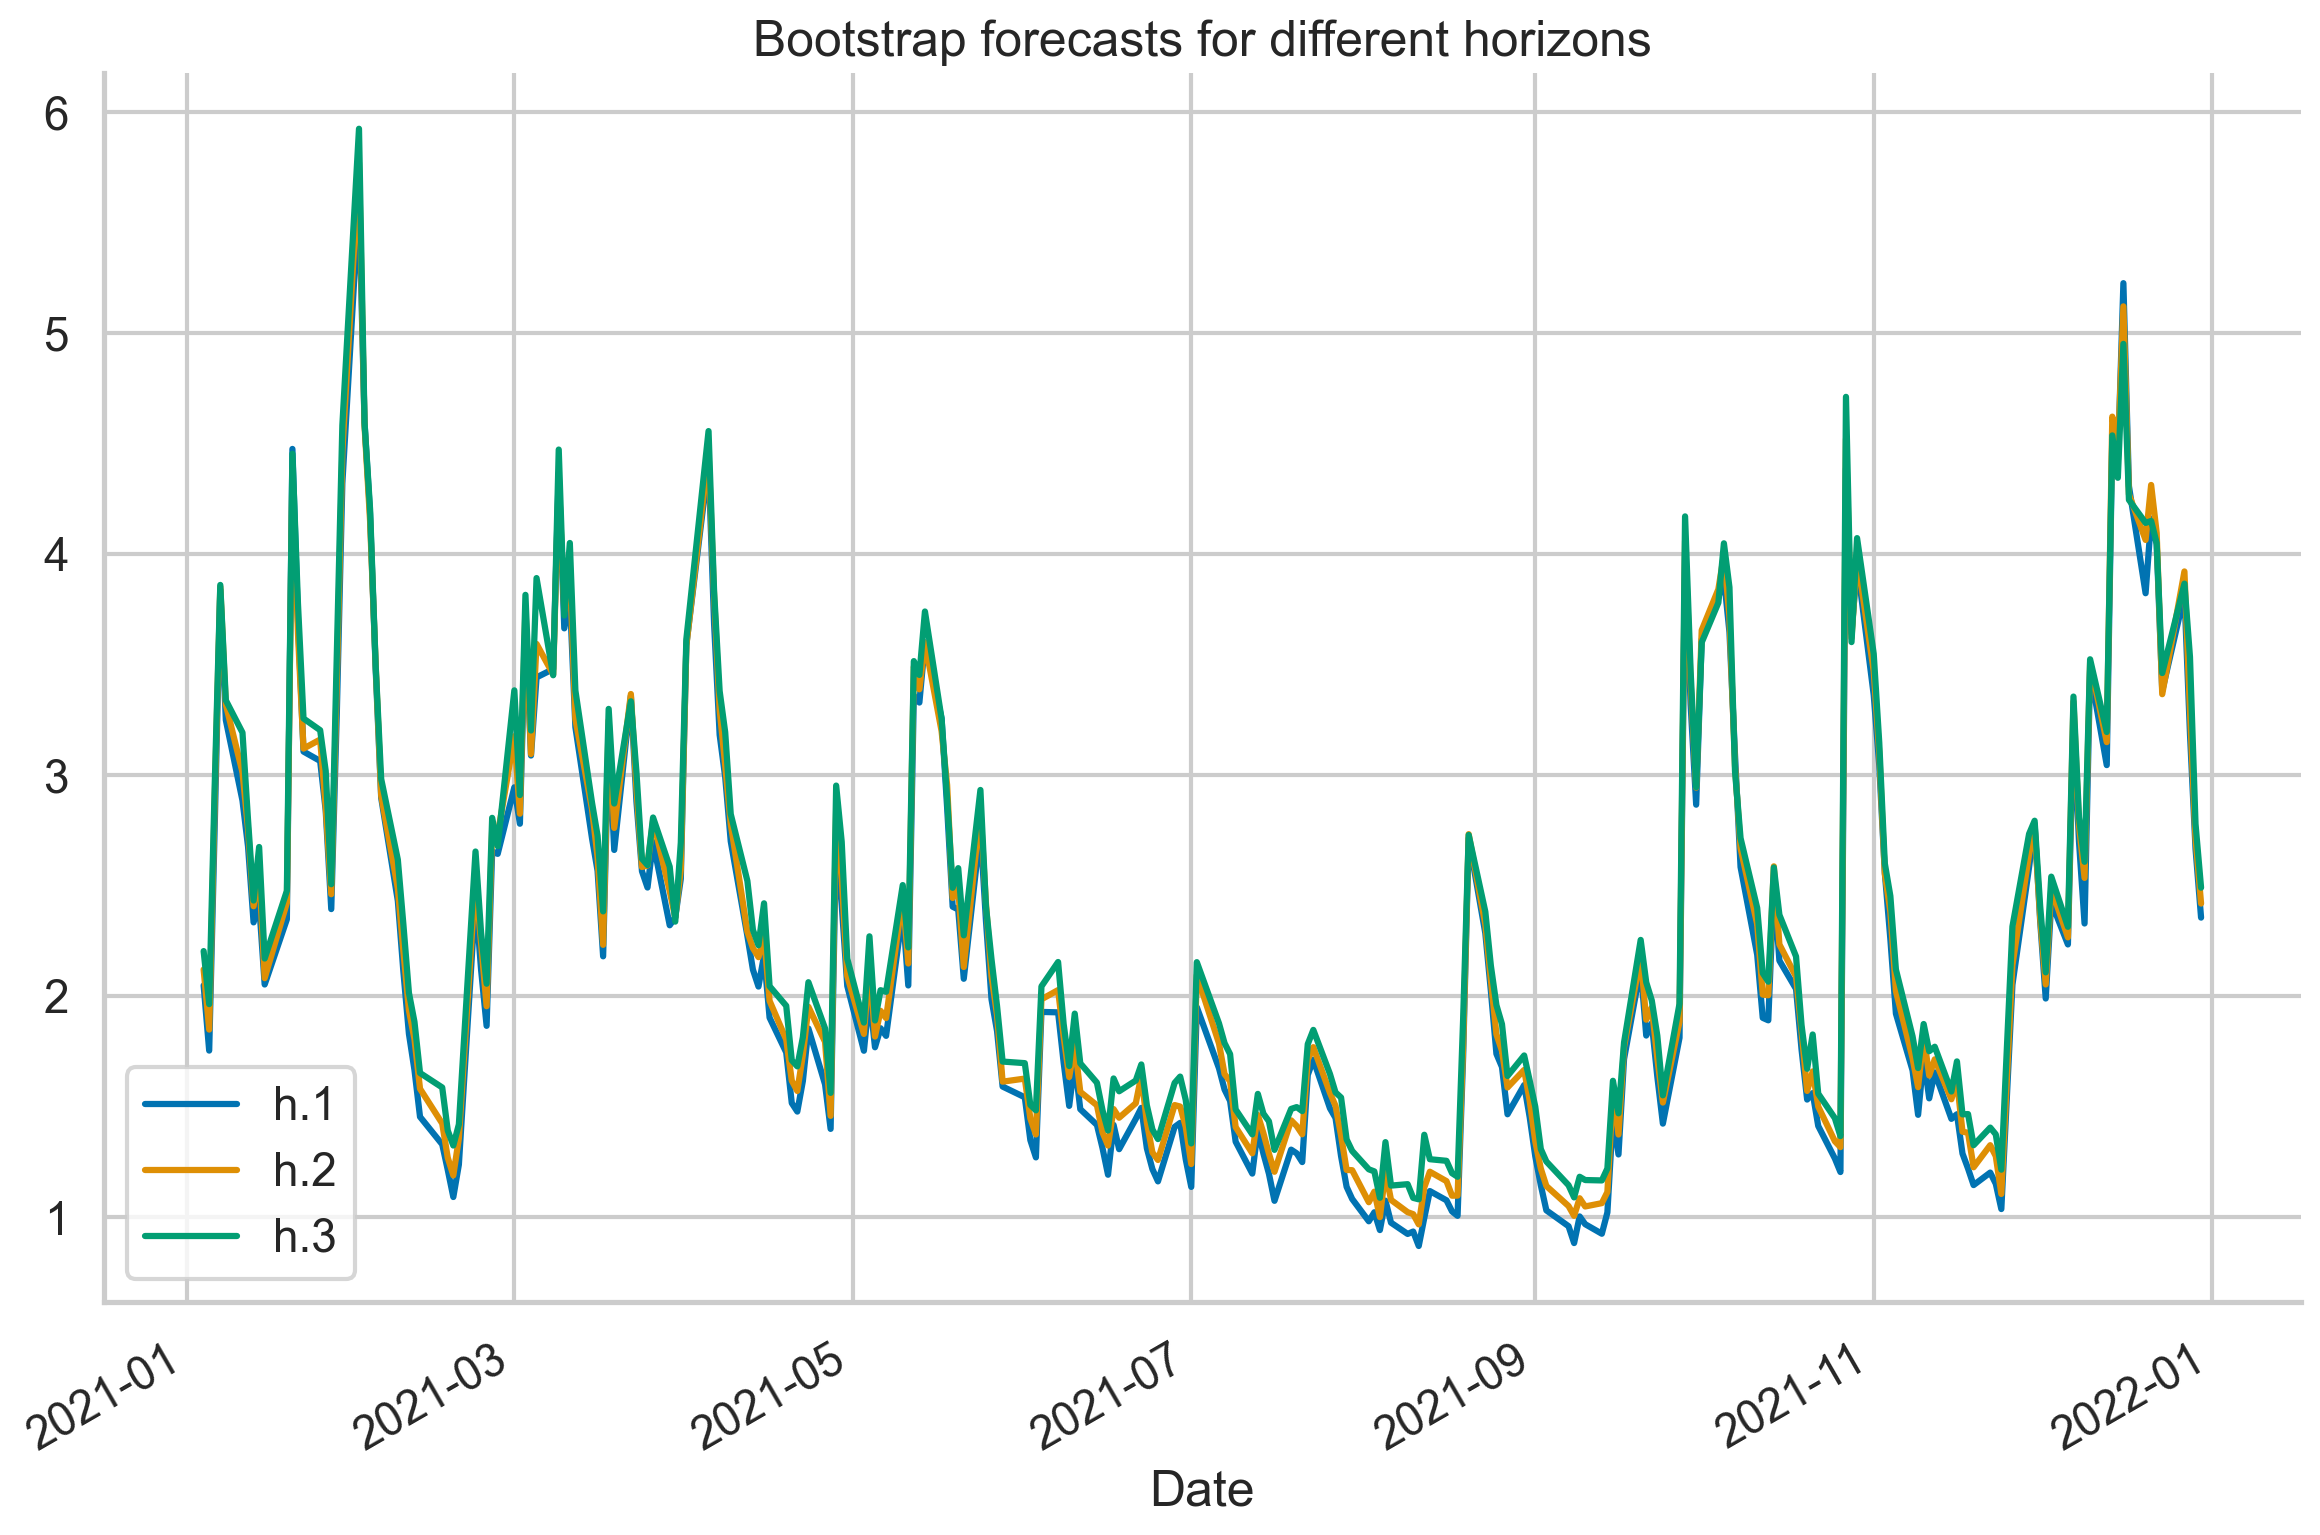

In [29]:
forecasts_bootstrap = fitted_model.forecast(horizon=3, 
                                            start=SPLIT_DATE,
                                            method="bootstrap",
                                            reindex=False)
forecasts_bootstrap.variance.plot(
    title="Bootstrap forecasts for different horizons"
)

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("images/figure_9_7", dpi=200)

In [30]:
forecasts_bootstrap.variance

h.1       h.2       h.3
Date                                    
2021-01-04  2.048968  2.121074  2.204081
2021-01-05  1.754037  1.849049  1.964222
2021-01-06  2.770921  2.892074  2.957898
2021-01-07  3.838424  3.852196  3.860149
2021-01-08  3.248879  3.318976  3.338341
...              ...       ...       ...
2021-12-23  3.380818  3.365936  3.461594
2021-12-27  3.817202  3.921086  3.865903
2021-12-28  3.185622  3.288353  3.534229
2021-12-29  2.666795  2.713052  2.778635
2021-12-30  2.355428  2.418938  2.490798

[251 rows x 3 columns]

### There's more

1. Import the libraries:

In [31]:
import numpy as np

2. Estimate the volatility forecasts for 2020 using the analytic and bootstrap approaches:

In [33]:
# define the forecast horizon
FCST_HORIZON = 10

vol_analytic = (
    fitted_model.forecast(horizon=FCST_HORIZON, 
                          start=datetime(2020, 1, 1),
                          reindex=False)
    .residual_variance.loc['20200101':'20201231']
    .apply(np.sqrt)
)

vol_bootstrap = (
    fitted_model.forecast(horizon=FCST_HORIZON, 
                          start=datetime(2020, 1, 1),
                          method="bootstrap",
                          reindex=False)
    .residual_variance.loc['20200101':'20201231']
    .apply(np.sqrt)
)


3. Get the conditional volatility for 2020:

In [34]:
vol = fitted_model.conditional_volatility["2020"]

4. Create the hedgehog plot:

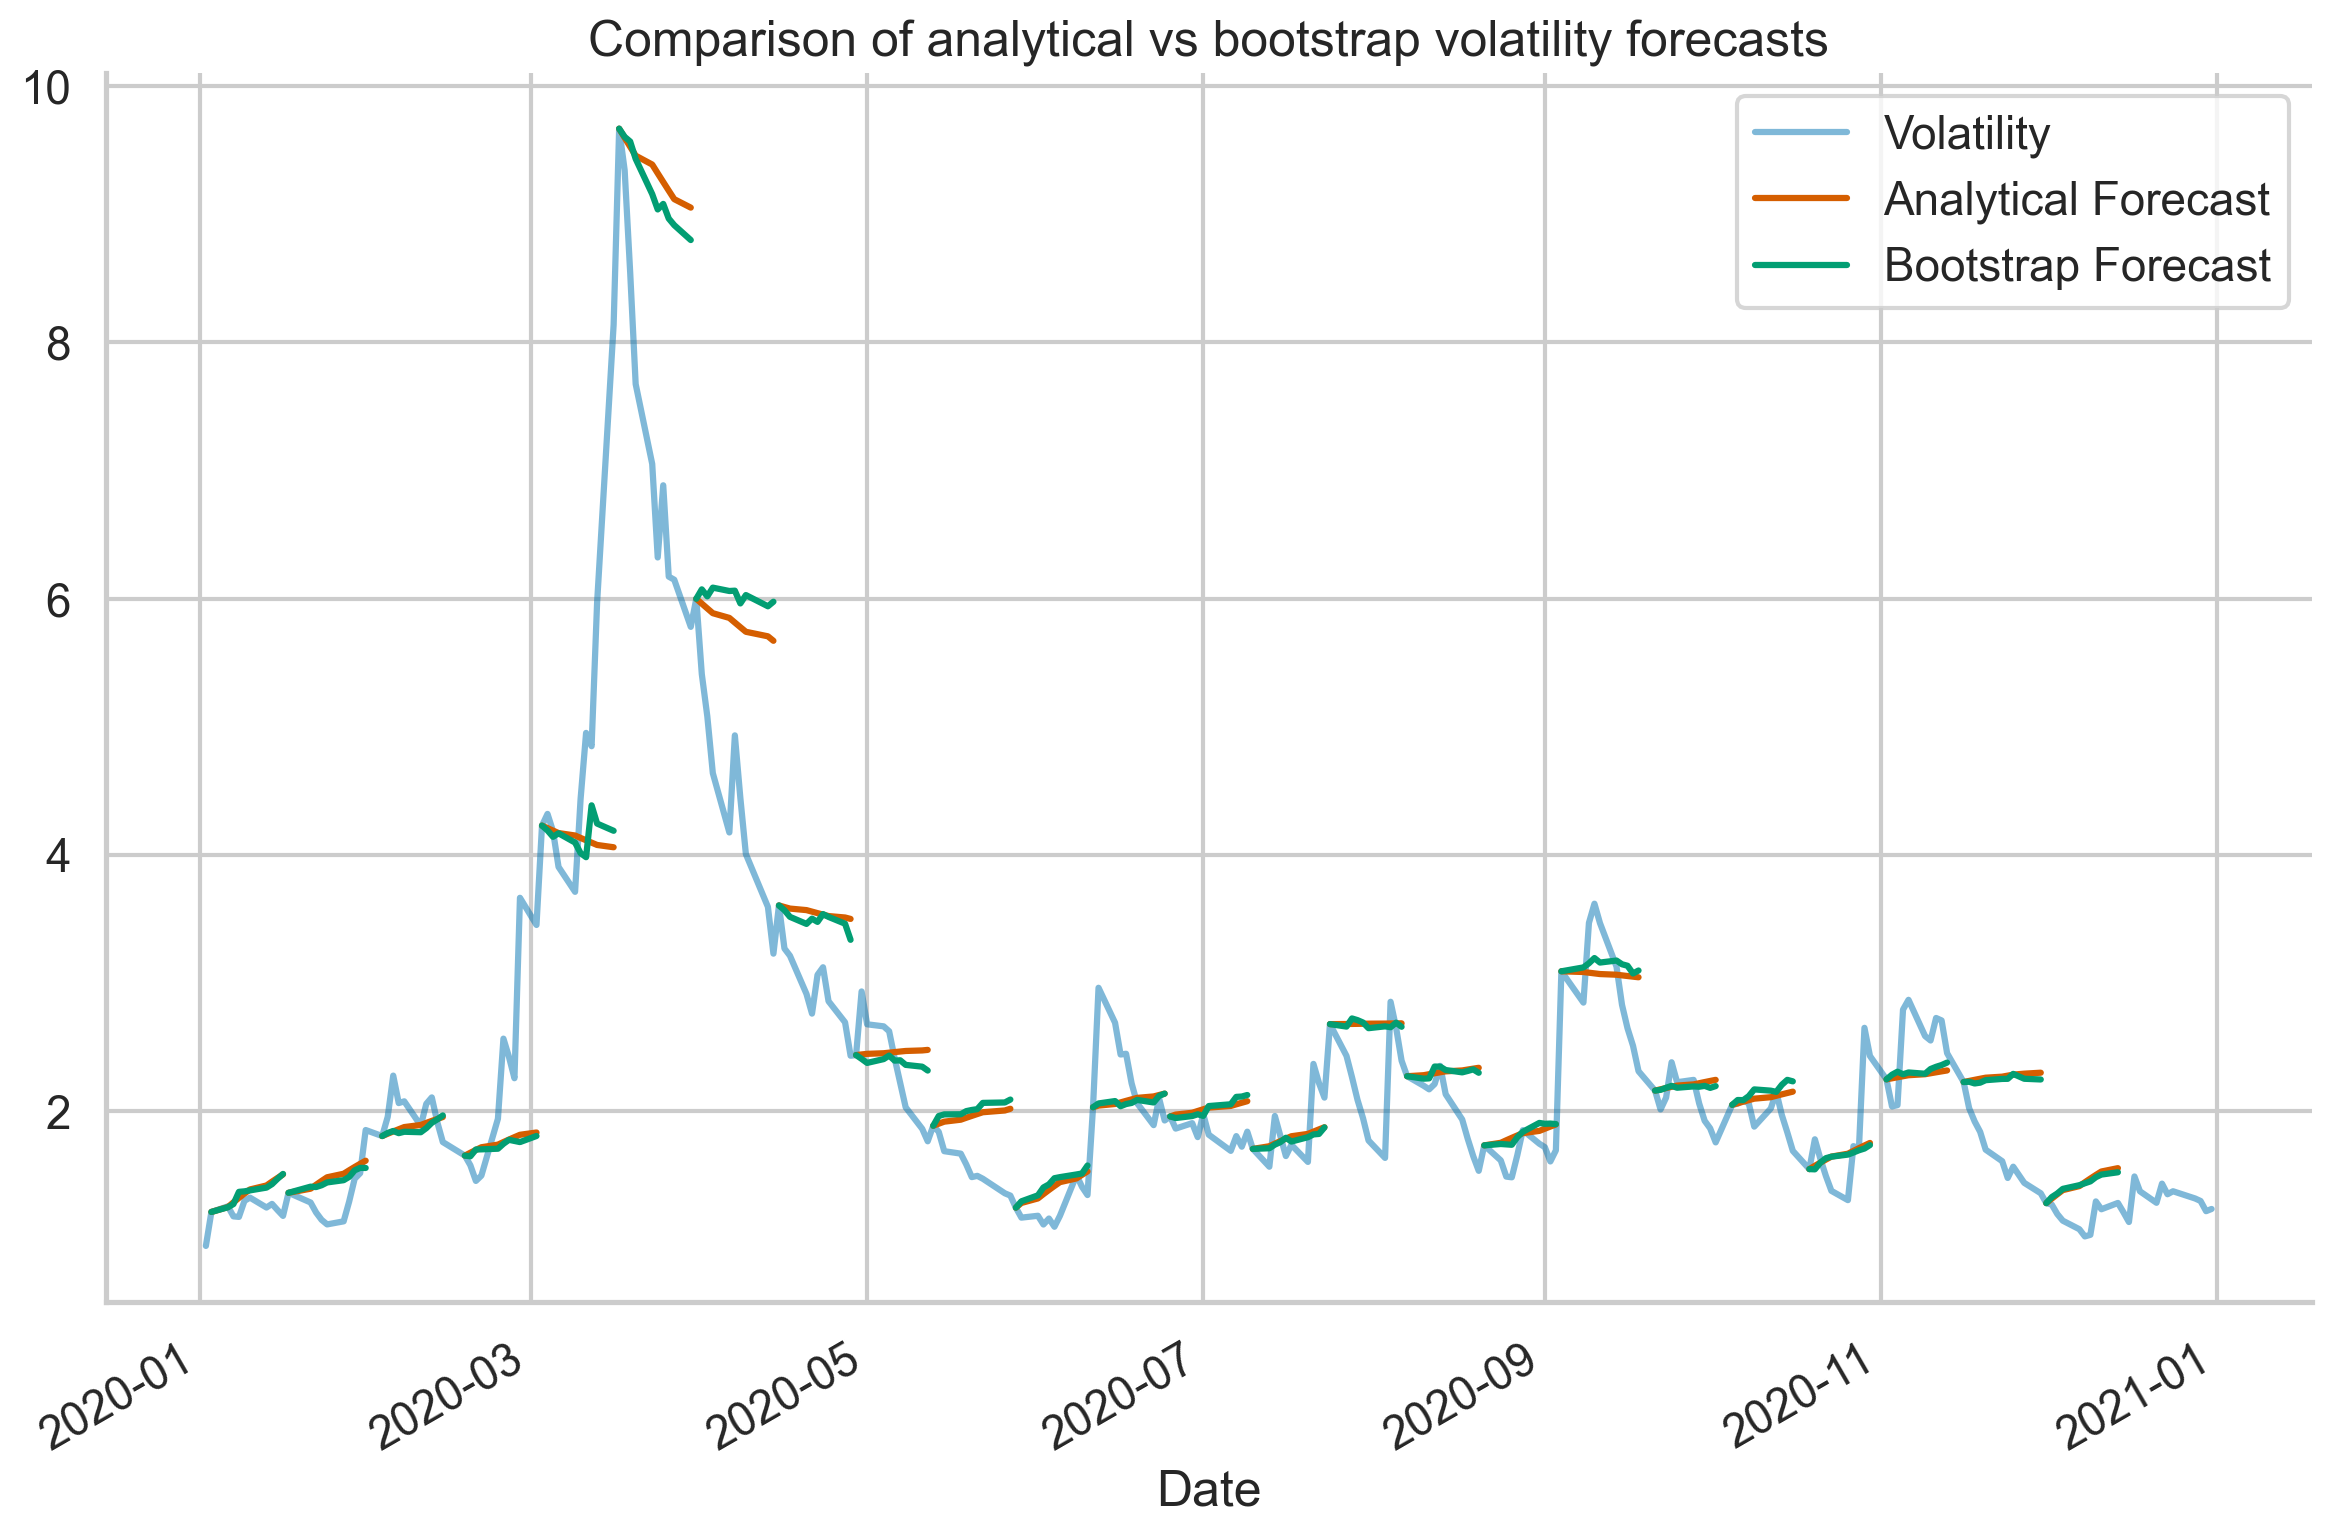

In [35]:
ax = vol.plot(
    title="Comparison of analytical vs bootstrap volatility forecasts",
    alpha=0.5
)
ind = vol.index

for i in range(0, 240, 10):
    vol_a = vol_analytic.iloc[i]
    vol_b = vol_bootstrap.iloc[i]
    start_loc = ind.get_loc(vol_a.name)
    new_ind = ind[(start_loc+1):(start_loc+FCST_HORIZON+1)]
    vol_a.index = new_ind
    vol_b.index = new_ind
    ax.plot(vol_a, color="r")
    ax.plot(vol_b, color="g")

labels = ["Volatility", "Analytical Forecast", "Bootstrap Forecast"]
legend = ax.legend(labels)

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("images/figure_9_8", dpi=200)


흥미로운 점 
- 2020년 3월에 변동성이 최고치를 찍는데 GARCH 모델은 이후 며칠 동안 낮아질 것을 예측한다.
- 실제 데이터를 보면 최고치는 3월 17일에 발생했고 모델 예측은 3월 16일까지의 데이터로 예측했다.

C:\Users\syahn\.conda\envs\cookbook\Lib\site-packages\arch\univariate\base.py:1613: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plot_fn(x_values, y_values, linestyle="-", marker="")
C:\Users\syahn\.conda\envs\cookbook\Lib\site-packages\arch\univariate\base.py:1628: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  line = plot_fn(temp_x, temp_y, linewidth=3, linestyle="-", marker="")


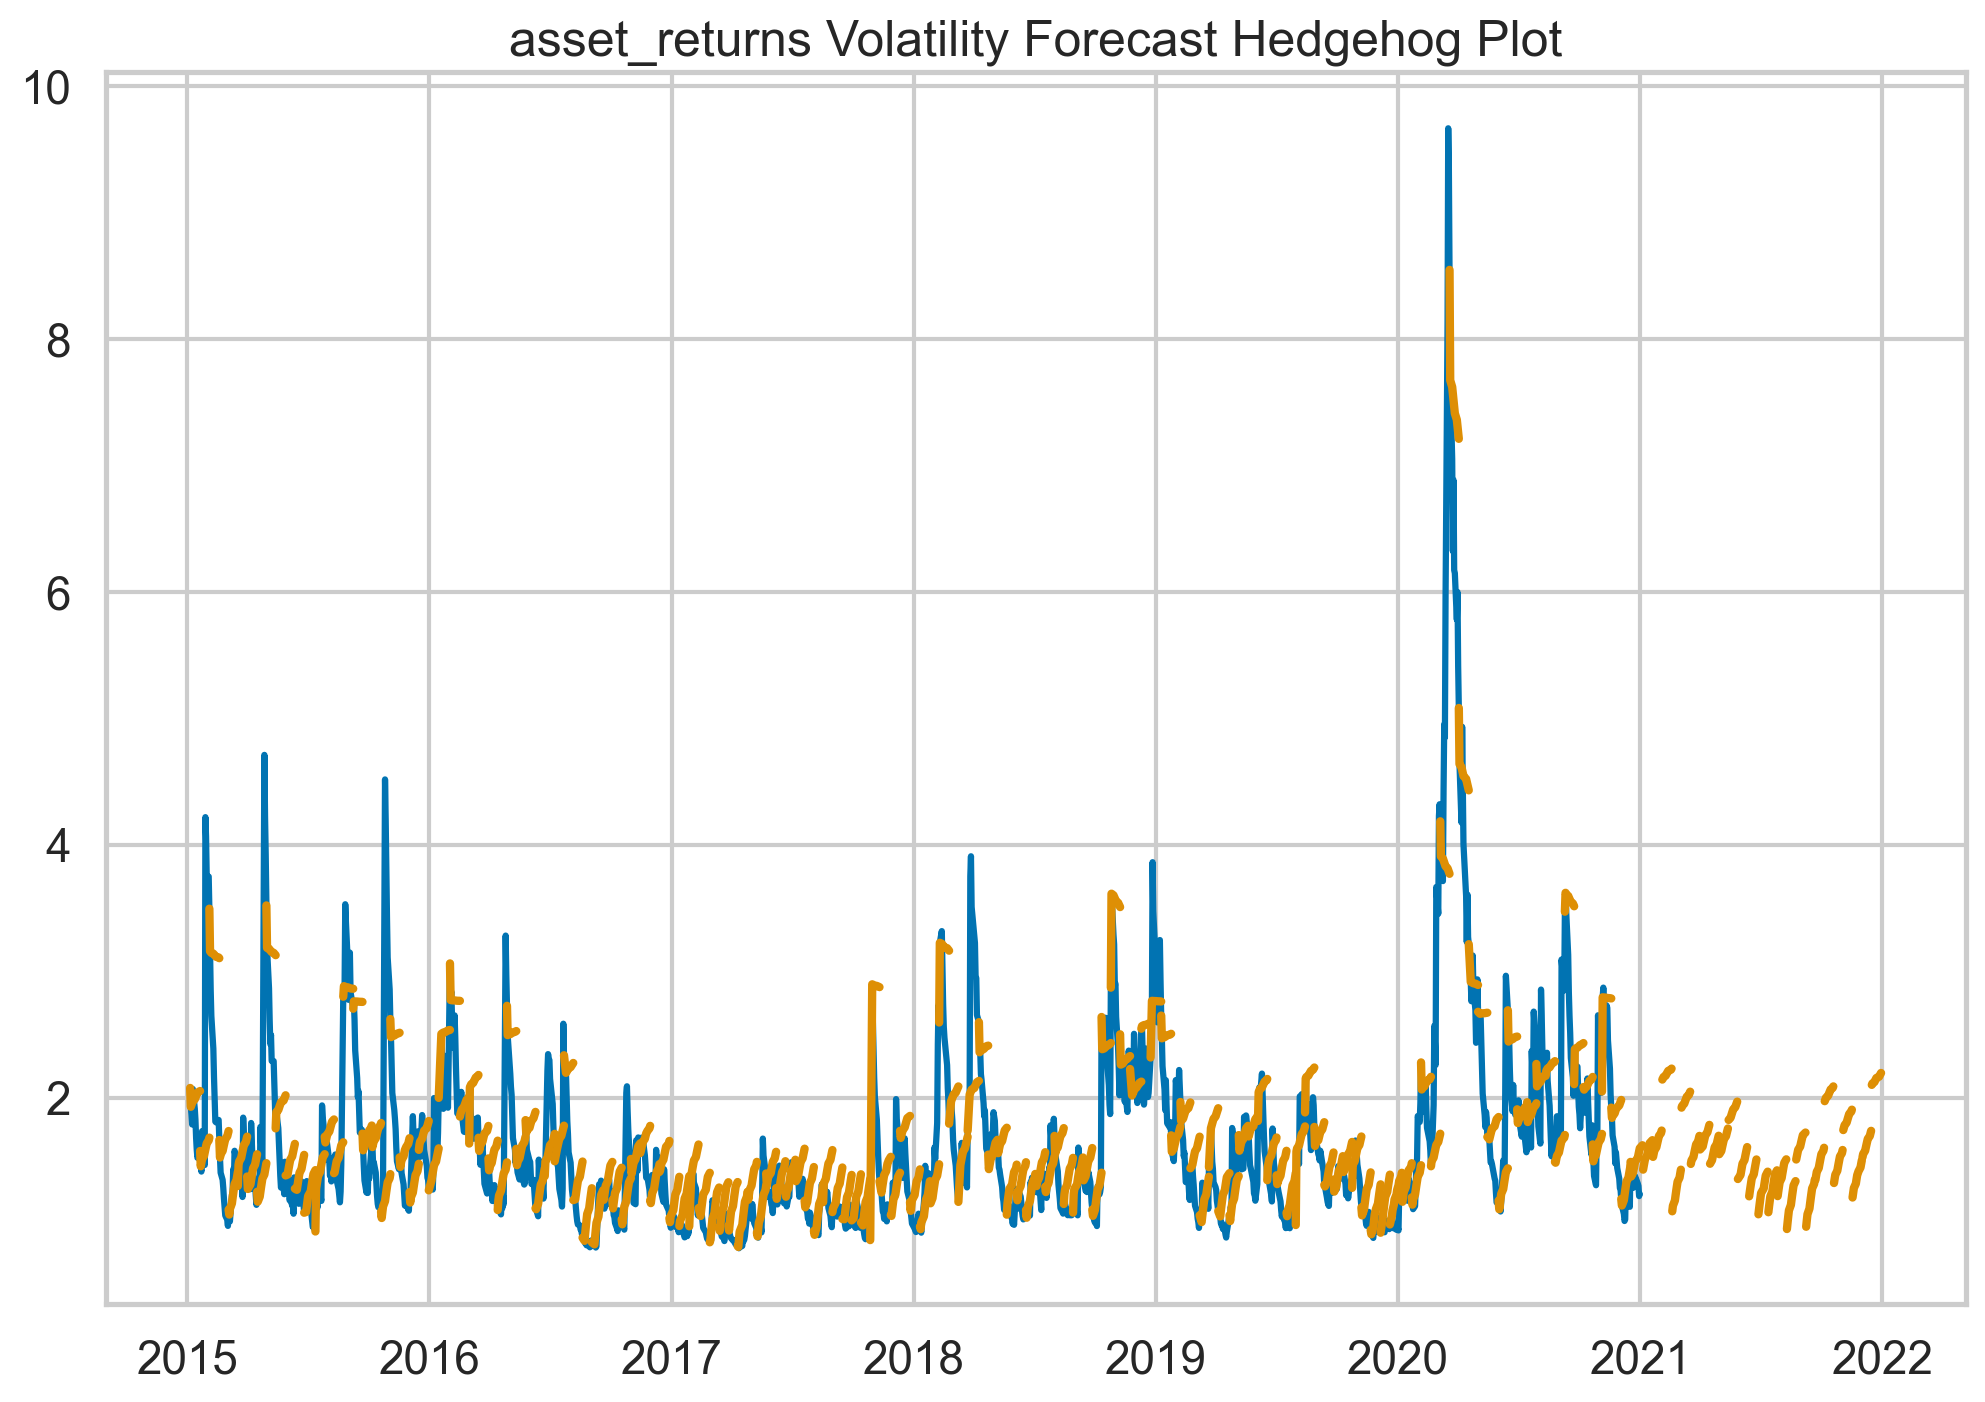

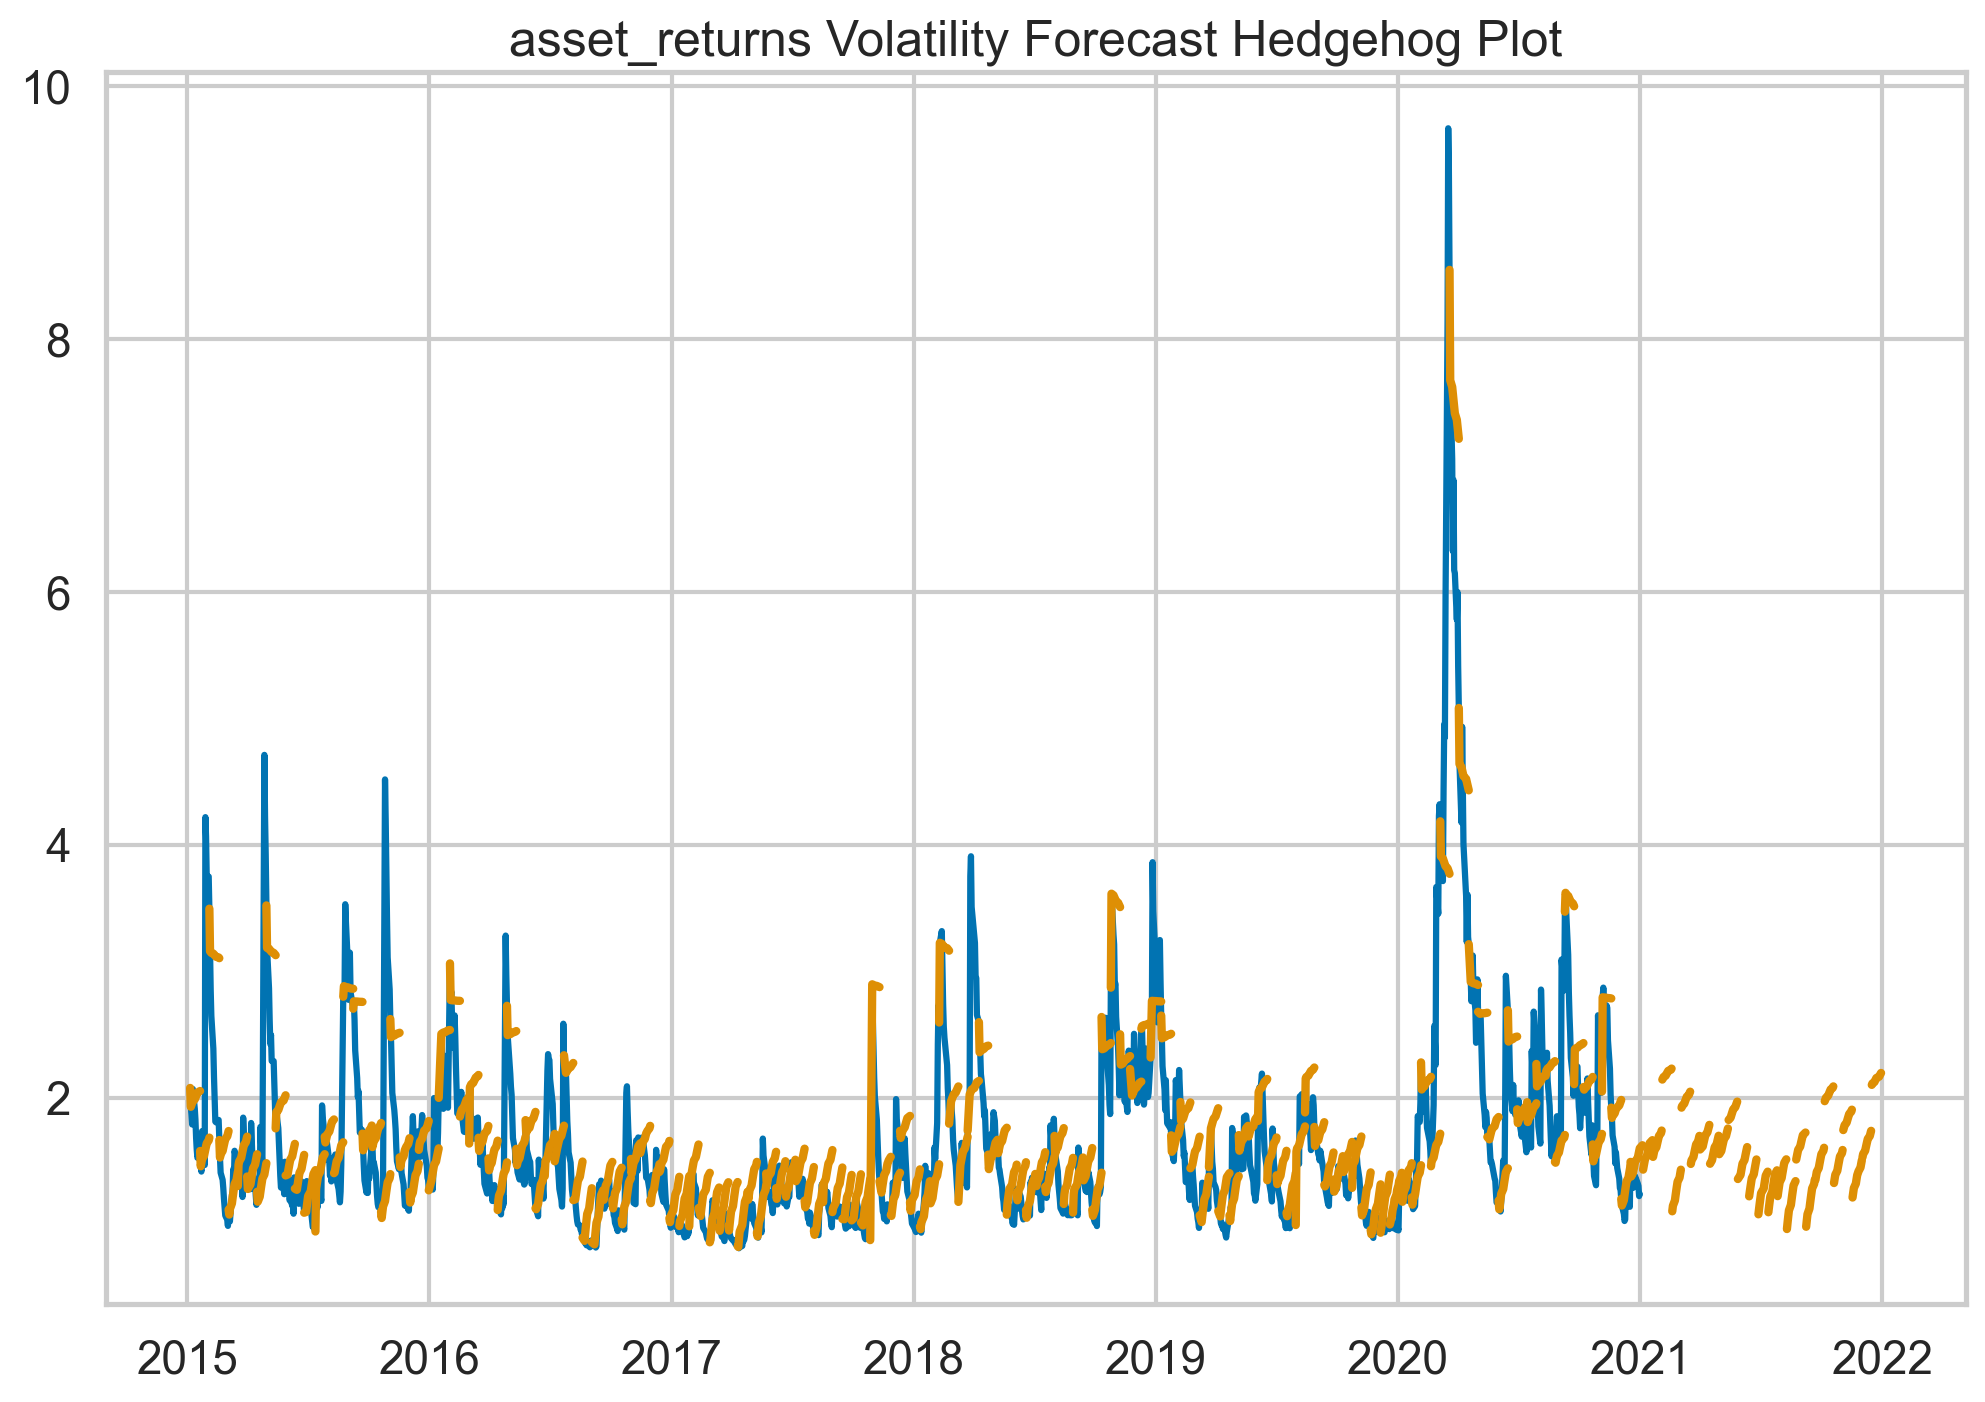

In [75]:
fitted_model.hedgehog_plot()

C:\Users\syahn\.conda\envs\cookbook\Lib\site-packages\arch\univariate\base.py:1613: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plot_fn(x_values, y_values, linestyle="-", marker="")
C:\Users\syahn\.conda\envs\cookbook\Lib\site-packages\arch\univariate\base.py:1628: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  line = plot_fn(temp_x, temp_y, linewidth=3, linestyle="-", marker="")


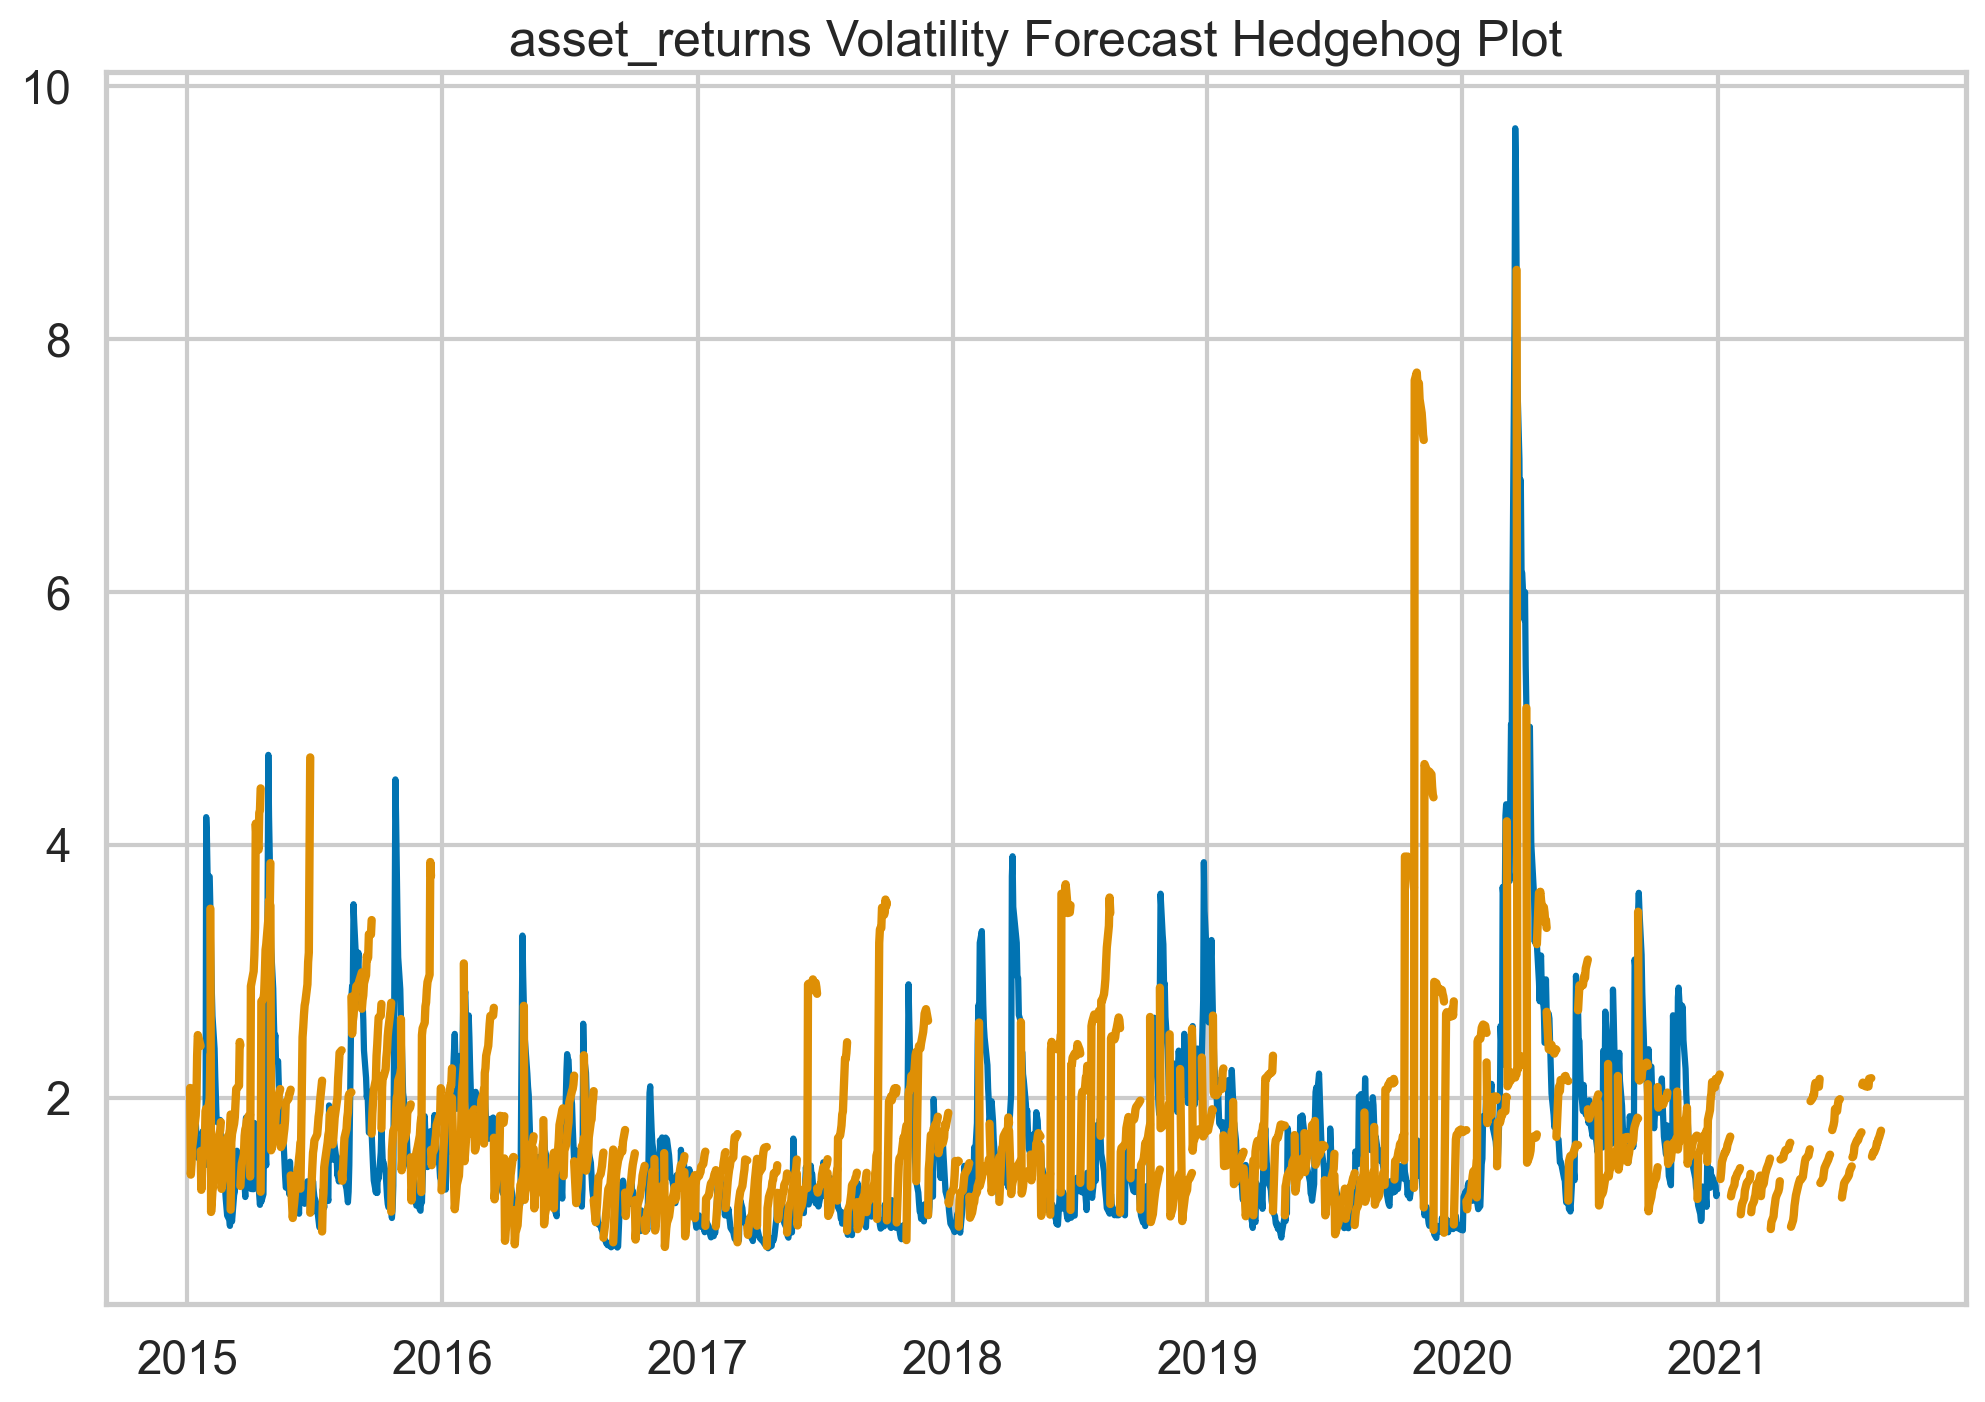

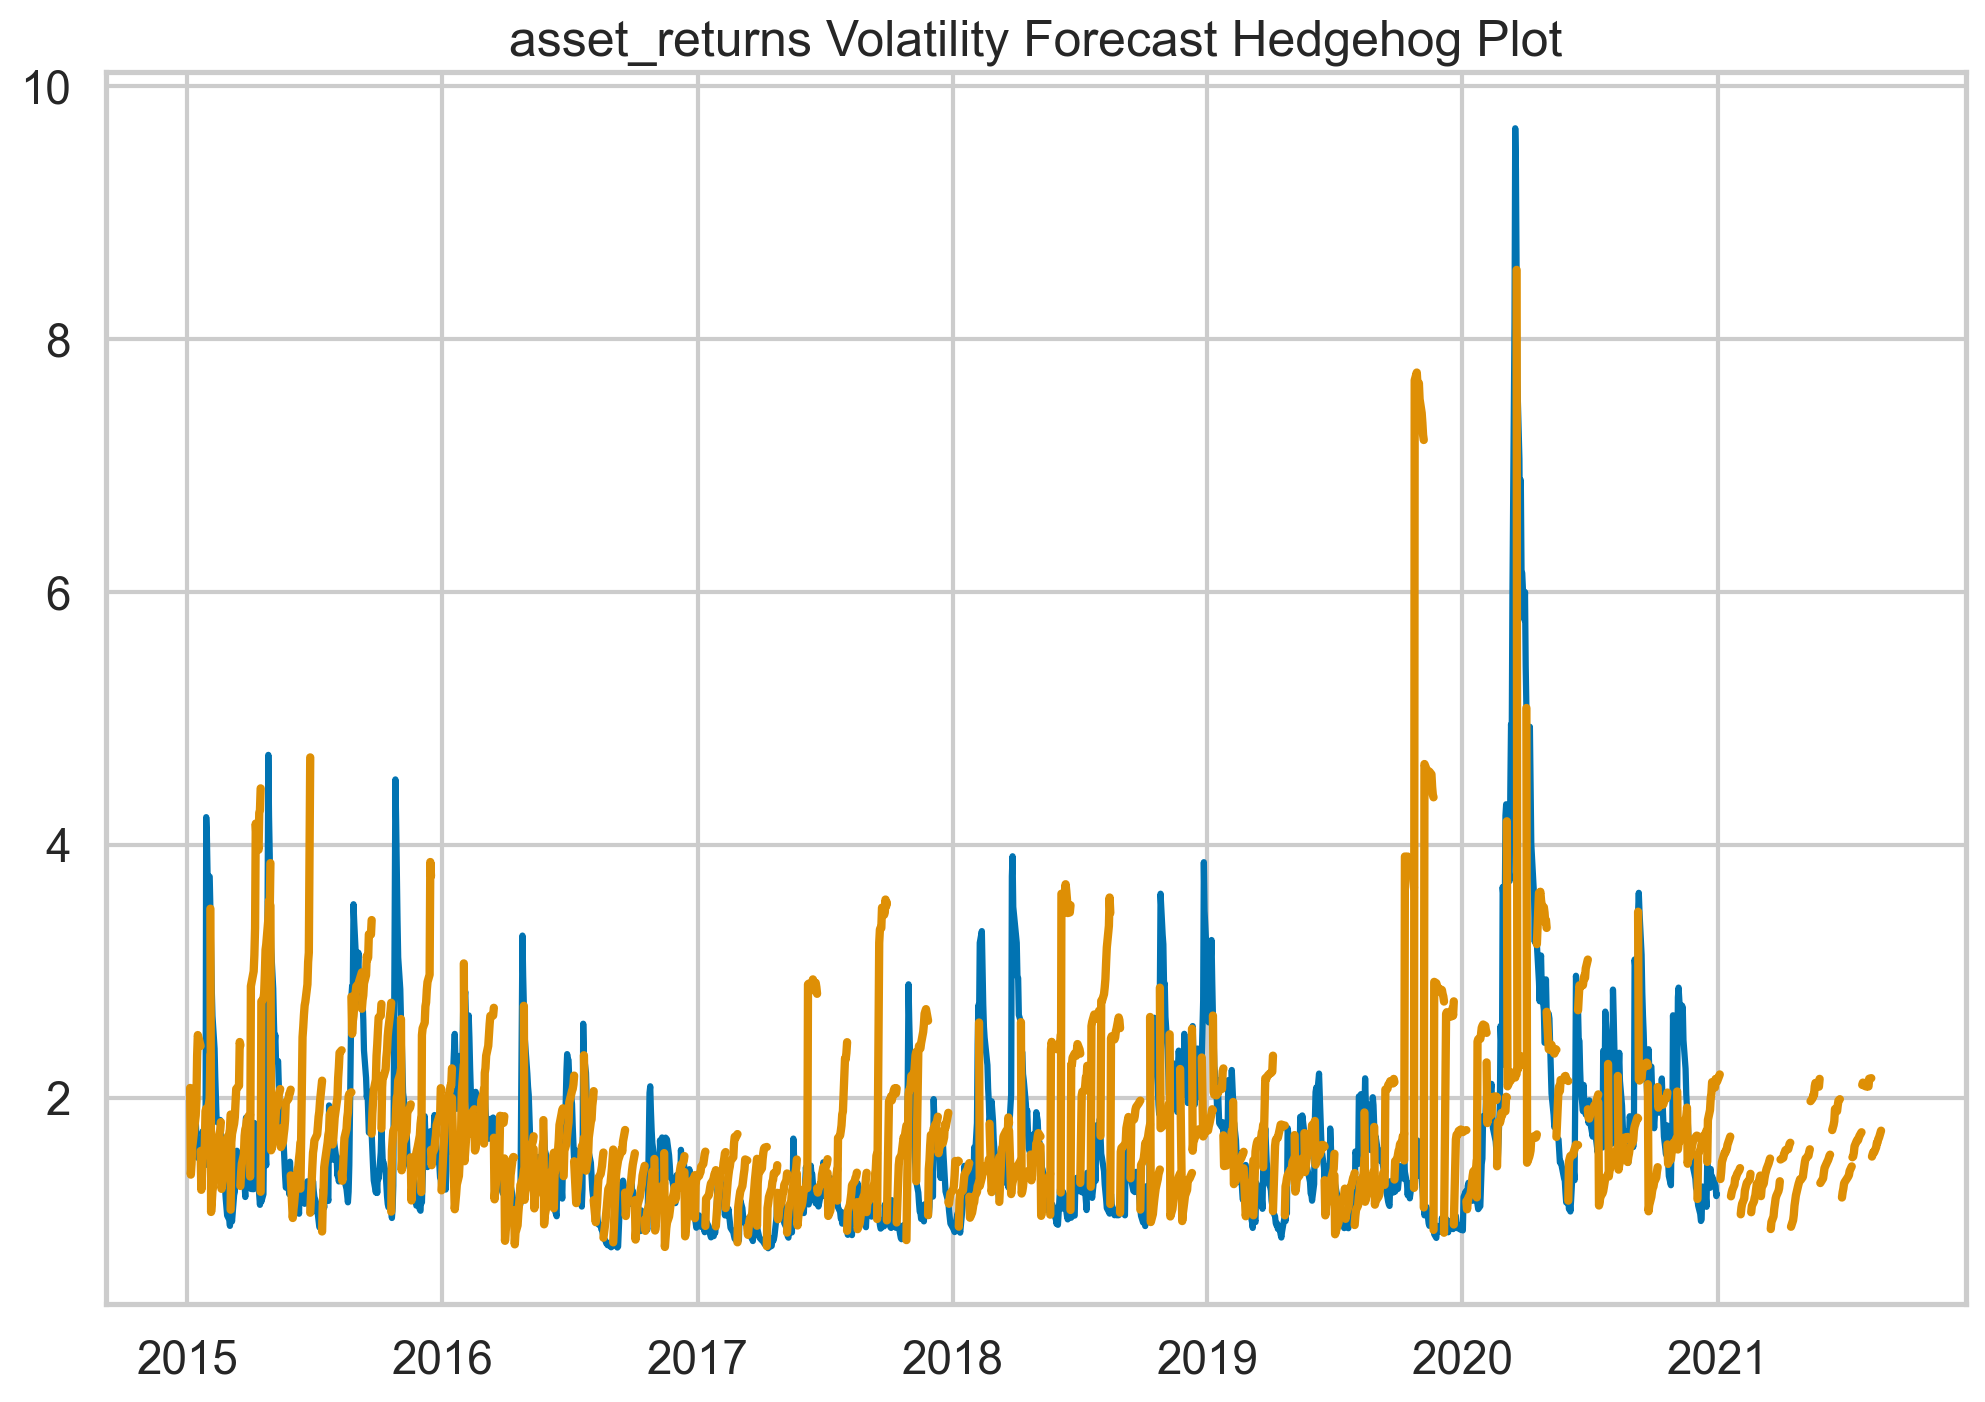

In [76]:
fitted_model.hedgehog_plot(method="bootstrap")

## 9.4 Multivariate volatility forecasting with the CCC-GARCH model

여러 개의 변동성을 한꺼번에 모델링 하는 방법으로 Constant Conditional Correlation GARCH (CCC-GARCH)를 사용한다.
- 여러 종목의 변동성을 한꺼번에 모델링
- 서로 간에 상관관계가 있는 경우에 유용하지 않을까?

CCC-GARCH 방법 설명
- N개의 단변수 GARCH 모델을 사용
- 서로 간의 관계는 constant conditional correlation matrix R을 추가

세부 내용을 설명하면 다음과 같다.
- 모델을 표현하는 공식

  - <img src="image/fig_09_03.png" width="150"/>
  - 굵은 글씨는 벡터 또는 행렬이다.
  - 두번째 공식은 에러가 조건부 공분산 행렬 Σ<sub>t</sub>와 zero-mean으로 표현되는 정규 분포라는 뜻

조건부 공분산 행렬(conditional covariance matrix) 공식
- <img src="image/fig_09_04.png" width="600"/>
- 대각선 부분인 분산과 그 외 부분인 상관관계를 분리
- 대각선 부분인 분산은 단변수 GARCH 모델을 사용
- 그 외부분인 상관관계는 상수 


### How to do it...

1. Import the libraries:

In [36]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

- 3개의 주식들의 return 값을 모델링

In [37]:
RISKY_ASSETS = ["GOOG", "MSFT", "AAPL"]
START_DATE = "2015-01-01"
END_DATE = "2021-12-31"

3. Download data from Yahoo Finance:

In [38]:
df = yf.download(RISKY_ASSETS,
                 start=START_DATE,
                 end=END_DATE)
#                 end=END_DATE,
#                 adjusted=True)

print(f"Downloaded {df.shape[0]} rows of data.")

[*********************100%***********************]  3 of 3 completed

Downloaded 1762 rows of data.


4. Calculate daily returns:

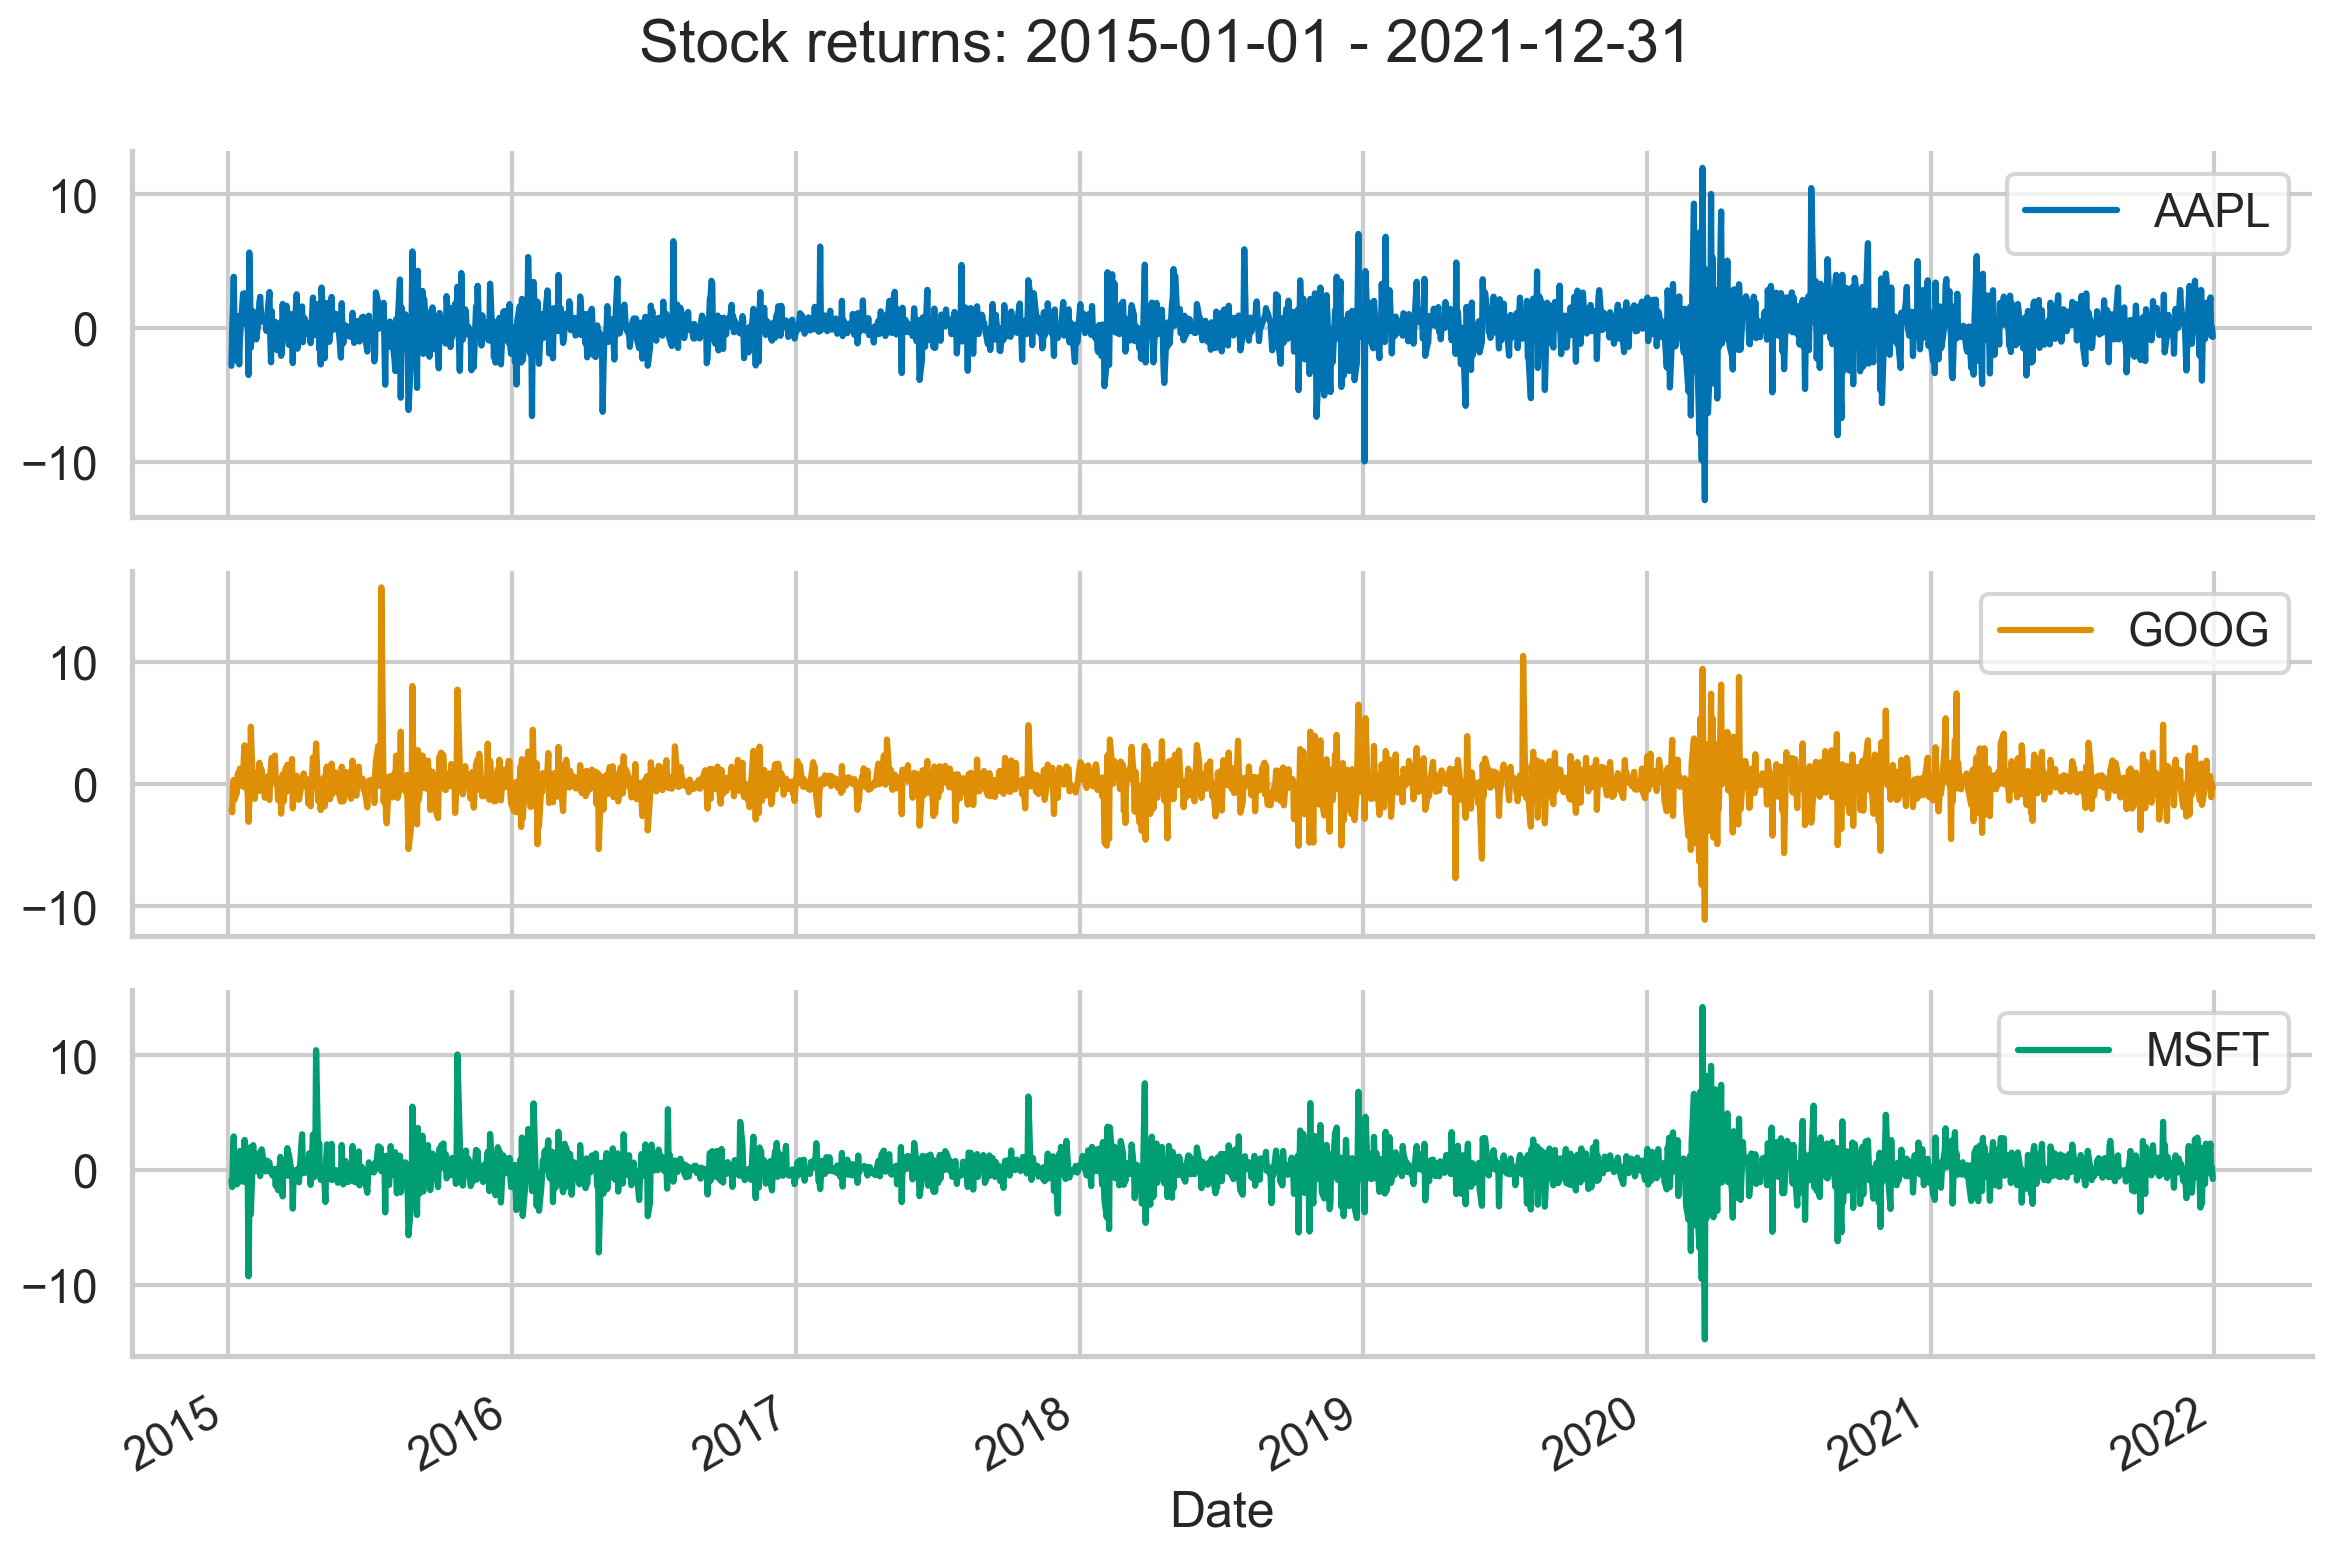

In [39]:
returns = 100 * df["Adj Close"].pct_change().dropna()
returns.plot(subplots=True, 
             title=f"Stock returns: {START_DATE} - {END_DATE}")

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("images/figure_9_9", dpi=200)

5. Define lists for storing objects:

In [40]:
coeffs = []
cond_vol = []
std_resids = []
models = []

6. Estimate the univariate GARCH models:

각각에 대해서 단변수 GARCH를 돌린다.

In [41]:
for asset in returns.columns:
    # specify and fit the model
    model = arch_model(returns[asset], mean="Constant", 
                       vol="GARCH", p=1, q=1)
    model = model.fit(update_freq=0, disp="off");
    
    # store results in the lists 
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.std_resid)
    models.append(model)

7. Store the results in DataFrames:

In [42]:
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = (
    pd.DataFrame(cond_vol)
    .transpose()
    .set_axis(returns.columns,
              axis="columns")
)
std_resids_df = (
    pd.DataFrame(std_resids)
    .transpose()
    .set_axis(returns.columns, 
              axis="columns")
)

In [43]:
coeffs_df

mu     omega  alpha[1]   beta[1]
Ticker                                        
AAPL    0.189583  0.176260  0.134657  0.811613
GOOG    0.125469  0.305894  0.183854  0.715030
MSFT    0.149252  0.267586  0.213114  0.700489

8. Calculate the constant conditional correlation matrix (R):

다음 공식으로 matrix를 계산

- <img src="image/fig_09_05.png" width="150"/>
- z<sub>t</sub>는 t 시간의 표준화된 residual
- 표준화된 residual 전체값을 이용해서 상수인 R을 계산한다.

In [44]:
R = (
    std_resids_df
    .transpose()
    .dot(std_resids_df)
    .div(len(std_resids_df))
)

9. Calculate the 1-step ahead forecast of the conditional covariance matrix :

In [45]:
# define objects
diag = []
D = np.zeros((len(RISKY_ASSETS), len(RISKY_ASSETS)))

# populate the list with conditional variances
for model in models:
    diag.append(model.forecast(horizon=1).variance.iloc[-1, 0])
# take the square root to obtain volatility from variance
diag = np.sqrt(diag)
# fill the diagonal of D with values from diag
np.fill_diagonal(D, diag)

# calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D)

In [46]:
H

array([[2.398113  , 1.00565324, 1.19870532],
       [1.00565324, 1.51517912, 1.12098314],
       [1.19870532, 1.12098314, 1.87603391]])

## 9.5 Forecasting the conditional covariance matrix using DCC-GARCH

CCC-GARCH를 확장인 DCC-GARCH (Dynamic Conditional Correlation GARCH)를 설명
- CCC-GARCH에서는 R이 상수이지만 DCC-GARCH에서는 시간에 따라 변한다.
- CCC-GARCH와 비슷한 과정으로 R 계산하는 부분만 다르다.

R<sub>t</sub> 계산하는 부분을 설명
    
- <img src="image/fig_09_06.png" width="300"/>
- R<sub>t</sub>를 생성해 내는 proxy correlation process를 표현
- Q<sub>t</sub>를 이용해서 R<sub>t</sub>를 만들어 낸다.
- Q<sub>t</sub>는 γ 와 δ로 표현된다.
- DCC model은 correlation targeting 방법을 사용한다.

DCC-GARCH은 python으로 구현된 것이 없어서 R에서 구현된 것을 사용한다.

이를 위해서 R과 python을 연동하는 rpy2를 설치해서 사용한다.
- 설치은 되는데 데이터 연동이 잘 안됨...

### Getting ready

Before executing the following code, please make sure to run the code from the previous recipe to have the data available. 

### How to do it...

1. Import the libraries:

In [47]:
import pandas as pd

Setup the connection between Python and R using `rpy2`:

In [48]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


2. Install `rmgarch` R package and load it:

In [62]:
%%R

install.packages("rmgarch", repos = "http://cran.us.r-project.org")
library(rmgarch)

Exception ignored from cffi callback <function _consolewrite_ex at 0x000002AE15582A20>:
Traceback (most recent call last):
  File "C:\Users\syahn\.conda\envs\cookbook\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syahn\.conda\envs\cookbook\Lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc6 in position 1: invalid continuation byte


In [59]:
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri

import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

pandas2ri.activate()
rpy2.robjects.numpy2ri.activate()
print(returns)

with (ro.default_converter + pandas2ri.converter).context():
  r_from_returns = ro.conversion.get_conversion().py2rpy(returns)

r_from_returns

Ticker                         AAPL      GOOG      MSFT
Date                                                   
2015-01-05 00:00:00+00:00 -2.817151 -2.084566 -0.919521
2015-01-06 00:00:00+00:00  0.009405 -2.317708 -1.467758
2015-01-07 00:00:00+00:00  1.402247 -0.171316  1.270527
2015-01-08 00:00:00+00:00  3.842214  0.315297  2.941789
2015-01-09 00:00:00+00:00  0.107201 -1.295054 -0.840478
...                             ...       ...       ...
2021-12-23 00:00:00+00:00  0.364378  0.131677  0.447157
2021-12-27 00:00:00+00:00  2.297469  0.626259  2.318575
2021-12-28 00:00:00+00:00 -0.576714 -1.091412 -0.350423
2021-12-29 00:00:00+00:00  0.050210  0.038583  0.205151
2021-12-30 00:00:00+00:00 -0.657814 -0.342657 -0.769124

[1761 rows x 3 columns]


<rpy2.robjects.vectors.DataFrame object at 0x000002AE50CE6490> [19]
R classes: ('data.frame',)
[FloatSexpVector, FloatSexpVector, FloatSexpVector]
  AAPL: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x000002AE53D78E50> [14]
  GOOG: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x000002AE59E31DD0> [14]
  MSFT: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x000002AE50D4A250> [14]

3. Import the dataset into R:

In [ ]:
%%R -i returns
print(head(returns, 5))

4. Define the model specification:

In [ ]:
%%R

# define GARCH(1,1) model
univariate_spec <- ugarchspec(
    mean.model = list(armaOrder = c(0,0)),
    variance.model = list(garchOrder = c(1,1), 
                          model = "sGARCH"),
    distribution.model = "norm"
)

# define DCC(1,1) model
n <- dim(returns)[2]
dcc_spec <- dccspec(
    uspec = multispec(replicate(n, univariate_spec)),
    dccOrder = c(1,1),
    distribution = "mvnorm"
)

dcc_spec

5. Estimate the model:

In [ ]:
%%R
dcc_fit <- dccfit(dcc_spec, data=returns)
dcc_fit

6. Calculate the 5-step ahead forecasts:

In [ ]:
%%R
forecasts <- dccforecast(dcc_fit, n.ahead = 5)

7. Access the forecasts:

In [ ]:
%%R

# conditional covariance matrix
forecasts@mforecast$H
# conditional correlation matrix
forecasts@mforecast$R
# proxy correlation process
forecasts@mforecast$Q
# conditional mean forecasts
forecasts@mforecast$mu

### There's more

In [ ]:
%%R

# parallelized DCC-GARCH(1,1)

library("parallel")

# set up the cluster
cl <- makePSOCKcluster(3)

# define parallelizable specification
parallel_fit <- multifit(multispec(replicate(n, univariate_spec)), 
                         returns, 
                         cluster = cl)

# fit the DCC-GARCH model
dcc_fit <- dccfit(dcc_spec, 
                  data = returns, 
                  fit.control = list(eval.se = TRUE), 
                  fit = parallel_fit, 
                  cluster = cl)

# stop the cluster
stopCluster(cl)

In [ ]:
%%R

dcc_fit

## BOXX ETF에 대한 설명

BOXX ETF 란?
- 미국에 상장된 파생상품 ETF
- https://etfsite.alphaarchitect.com/boxetf/
- 특징
  - S&P 500 지수 옵션을 사용해서 box spread 전략을 사용
  - 무위험 이자 수익을 추구 (Treasury Bill과 비슷한 위험/수익을 추구)
  - Total return으로 배당 수익이 아니라 양도 수익이 발생
- 과거 차트
  - <img src="image/fig_09_07.png" width="600"/>

Box spread 설명
- https://en.wikipedia.org/wiki/Box_spread
- 풋 콜 패리티 : 동일한 행사 가격 K에서 롱 유럽 콜 c와 숏 유럽 풋 p를 함께 사용하면 Ke<sup>-rT</sup>를 차입해서 S 가격에 주식을 매입한 것과 동일합니다. 다시 말해서, 우리는 현금과 옵션을 결합하여 합성 주식을 구성할 수 있습니다.
  - c - p = S - Ke<sup>-rT</sup>
- K<sub>1</sub>과 K<sub>2</sub>에 대해서 공식을 적용하면
  - c<sub>1</sub> - p<sub>1</sub> = S - K<sub>1</sub>e<sup>-rT</sup>
  - c<sub>2</sub> - p<sub>2</sub> = S - K<sub>2</sub>e<sup>-rT</sup>
- 두 공식의 양변을 빼면
  - c<sub>1</sub> + p<sub>2</sub> - c<sub>2</sub> - p<sub>1</sub> = K<sub>2</sub>e<sup>-rT</sup> - K<sub>1</sub>e<sup>-rT</sup>
  - S 가 수식에서 사라짐
- 구성 방법 (K<sub>1</sub> < K<sub>2</sub>)
| |Long bull call-spread|Long bear put-spread|
|--|--|--|
|Long synthetic stock|Buy call at K<sub>1</sub>|Sell put at K<sub>1</sub>|
|Short synthetic stock|Sell call at K<sub>2</sub>|Buy put at K<sub>2</sub>|

예시

- 예를 들어, 현재 가격이 100달러인 주식에 대한 3개월 옵션을 생각해 보세요. 이자율이 연 8%이고 변동성이 연 30%인 경우 옵션 가격은 다음과 같습니다.

| |call|put|
|--|--|--|
|K<sub>1</sub>=90|\$13.10|\$1.65|
|K<sub>2</sub>=110|\$3.05|\$10.90|

롱 박스 스프레드의 초기 투자는 $19.30입니다. 다음 표는 터미널 주가의 세 가지 값 범위에 대한 4개 옵션의 수익률을 표시합니다.
S<sub>T</sub>에 따른 구분:

|S<sub>T</sub> < K<sub>1</sub>|K<sub>1</sub> < S<sub>T</sub> < K<sub>2</sub>|K<sub>2</sub> < S<sub>T</sub>|
|--|--|--|
|0, S<sub>T</sub> - 90|S<sub>T</sub> - 90, 0|S<sub>T</sub> - 90, 0|
|0, 110 - S<sub>T</sub>|0, 110 - S<sub>T</sub>|110 - S<sub>T</sub>, 0|

터미널 페이오프는 주가의 터미널 가치와 무관하게 `$20`의 가치를 갖습니다. 페이오프의 할인된 가치는 
`$19.60`입니다. 따라서 롱 박스 스프레드에 투자하면 명목상 이익 30센트를 얻을 수 있습니다.

### 왜 이런 ETF를 관심을 가지게 되었나?

배당 이익이 커지면 세금 문제가 생길 수 있음
- 금융소득 종합과세
  - 2천만원 이상일 때 과세 대상이 됨
  - 실제 세금이 늘어나는 건 종합과세소득이 7900만원을 넘어야함.
  - 대신 대상자가 되면 ISA 등 불이익 발생
- 건강보험 소득월액 보험료
  - 직장인의 경우 근로소득 외 소득이 2천만원이 넘으면 소득월액 보험료가 발생 (약 8%)
  - 금융소득은 1천만원이 넘으면 소득월액 보험료 계산에 포함됨

미국의 경우 Total Return ETF가 거의 없음
- ETF의 경우 발생한 소득을 배당하지 않을 경우 세금 문제가 발생해서 대부분 배당함.
- 무위험에 가까운 단기 채권 ETF의 경우 모두 배당을 할 수 밖에 없는 구조임
- 굳이 단기 채권 달러화 ETF에 투자하고자 하면 미국 외에 상장된 ETF를 사야함
  - 영국의 FLOA, IB01 같은 ETF가 가능한데 매매수수료가 높음
   
Total Return으로 투자할만한 달러화 증권들
- 버크셔 해서웨이
- 자사주 매입 및 소각만하고 배당하지 않는 주식들
- 영국에 상장된 UCITS이면서 ACC인 ETF들
  - CNDX, VUAA
- BOXX

아니면, 투자용 법인을 설립하는 방법...